# **Feature Engineering Notebook**

## Objectives

* Engineer features for Classification and Regression models

## Inputs

* outputs/datasets/cleaned/BTCClean.csv

## Outputs

* Generate a list of variables to transform and select for regression and classification models.
* outputs/datasets/cleaned/BTCAugmented.csv

## Additional Comments

Two separate pipelines have been created to tailor the feature engineering process for each target variable: one for the classification model predicting 'buy/sell', and another for the regression model predicting 'close'. This ensures that each pipeline only processes the relevant features for its respective task, applying the appropriate transformations and correlation selections.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/bitcoin-forecast/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/bitcoin-forecast'

# Load Cleaned Data

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/cleaned/BTCClean.csv", index_col='date', parse_dates=True)
df.head()

open    high     low   close  Volume BTC  Volume USD
date                                                              
2014-11-28  363.59  381.34  360.57  376.28  3220878.18     8617.15
2014-11-29  376.42  386.60  372.25  376.72  2746157.05     7245.19
2014-11-30  376.57  381.99  373.32  373.34  1145566.61     3046.33
2014-12-01  376.40  382.31  373.03  378.39  2520662.37     6660.56
2014-12-02  378.39  382.86  375.23  379.25  2593576.46     6832.53

---

# Feature Augmentation

In this phase, the available features will be utilized to compute additional relevant features that are expected to enhance the performance of a model fitting to this dataset. This will involve appending new calculations to the dataframe, such as volume-weighted average price, lower and upper shadows, as well as MACD.

In [5]:
import numpy as np

#Sources: 
# https://www.kaggle.com/code/oreofeolurin/hourly-btc-usd-stock-prediction-with-lstms/notebook#Feature-Engineering
# https://medium.com/@maneesh1.kumar/macd-analysis-made-easy-with-python-23fd55dab90b


def new_features(df):

    df['price mean'] = df[['open', 'high', 'low', 'close']].mean(axis = 1)
    df['upper shadow'] = df['high'] - np.maximum(df['open'], df['close'])
    df['lower shadow'] = np.minimum(df['open'], df['close']) - df['low']
    df['spread'] = df['high'] - df['low']
    df['trade'] = df['close'] - df['open']
    
    # Calculate MACD
    df['12EMA'] = df['close'].ewm(span=12, adjust=False).mean()
    df['26EMA'] = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12EMA'] - df['26EMA']
     # Calculate buy/sell signals
    df['buy/sell'] = df['close'].diff(periods=1)
    df = df.copy().loc[df['buy/sell'].notna()]  # Remove NaN values from diff()
    df['buy/sell'] = df['buy/sell'].apply(lambda x: 0 if x <= 0 else 1)  # 0 for sell, 1 for buy

    return df


df = new_features(df)
df.head()

open    high     low   close  Volume BTC  Volume USD  \
date                                                                 
2014-11-29  376.42  386.60  372.25  376.72  2746157.05     7245.19   
2014-11-30  376.57  381.99  373.32  373.34  1145566.61     3046.33   
2014-12-01  376.40  382.31  373.03  378.39  2520662.37     6660.56   
2014-12-02  378.39  382.86  375.23  379.25  2593576.46     6832.53   
2014-12-03  379.25  383.00  374.23  376.67  2998357.92     7908.29   

            price mean  upper shadow  lower shadow  spread  trade       12EMA  \
date                                                                            
2014-11-29    377.9975          9.88          4.17   14.35   0.30  376.347692   
2014-11-30    376.3050          5.42          0.02    8.67  -3.23  375.884970   
2014-12-01    377.5325          3.92          3.37    9.28   1.99  376.270360   
2014-12-02    378.9325          3.61          3.16    7.63   0.86  376.728766   
2014-12-03    378.2875          3.75          2.44    8.77  -2.58  376.719725   

                 26EMA      MACD  buy/sell  
date                                        
2014-11-29  376.312593  0.035100         1  
2014-11-30  376.092401 -0.207430         0  
2014-12-01  376.262593  0.007766         1  
2014-12-02  376.483883  0.244883         1  
2014-12-03  376.497669  0.222056         0

---

# Data Exploration

It was observed that most features do not follow a normal distribution, necessitating appropriate transformations for modeling.

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Correlation and PPS Analysis

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predictive Score

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%    50%    75%    max
ppscore  210.0  0.284  0.358  0.0  0.0  0.125  0.391  0.979


The PPS analysis of the new dataset reveals a total of 210 feature pairs with a mean PPS score of 0.284, which is lower than the previous dataset's mean of 0.399. The new dataset shows a higher proportion of uncorrelated features, with 25% having a PPS score of 0.0, suggesting a diversification in relationships among features.

A correlation threshold of 0.4 will be maintained, as it captures relatively strong relationships.
This threshold may be raised in the future to reduce the inclusion of weak relationships.

Display Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



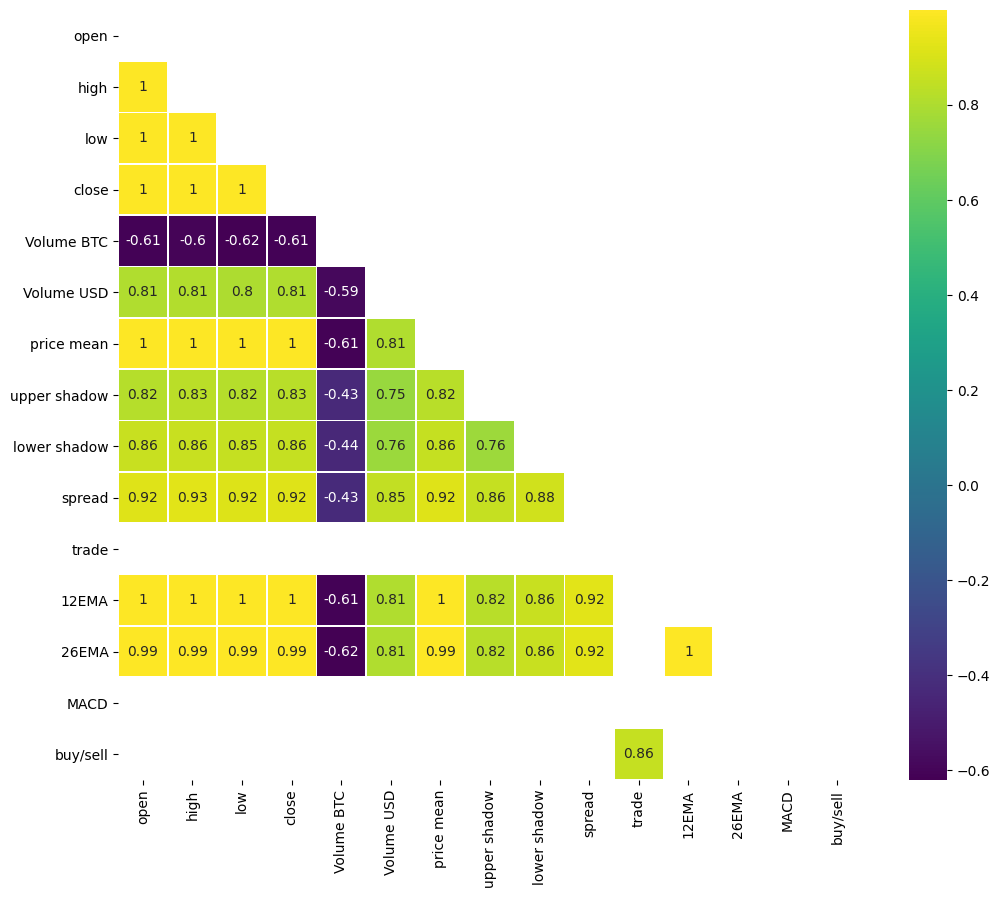



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



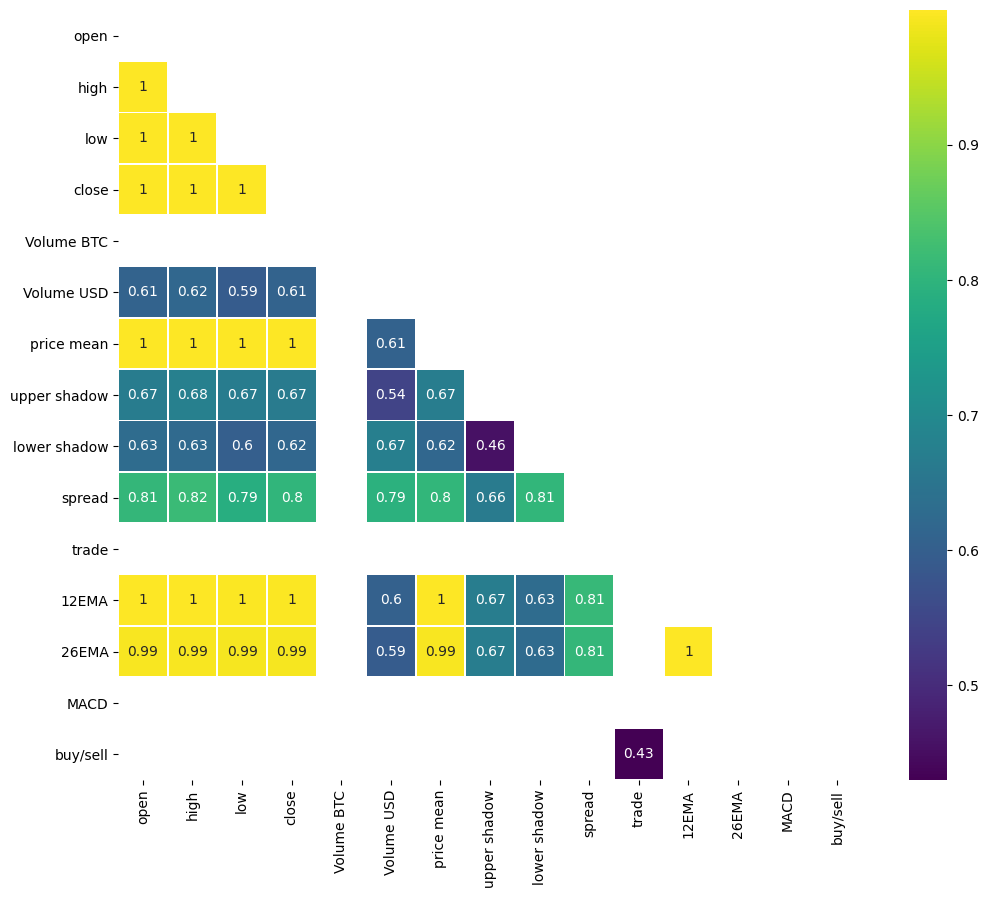



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



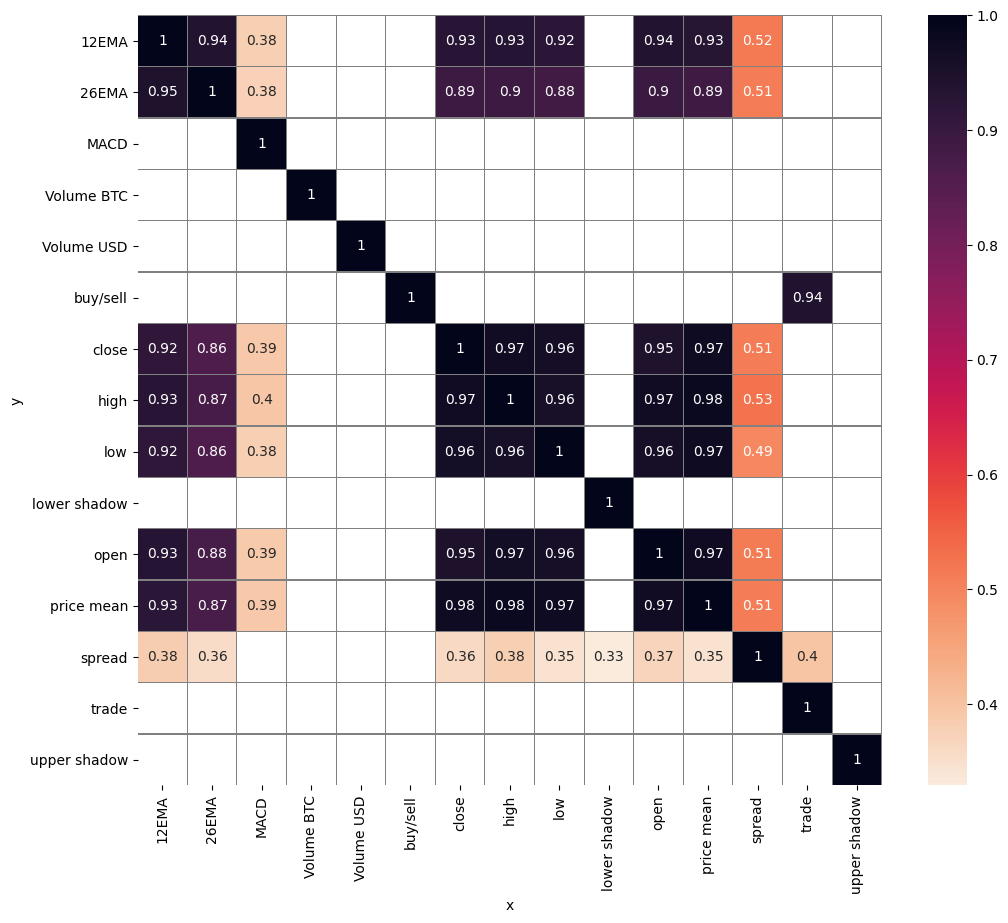

In [9]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.3,
                  figsize=(12,10), font_annot=10)

# Feature Engineering

We want to perfom a numerical analisys on the variables. It was observed that the Yeo-Johnson transformer performs as well or better than other transformers on most variables, making it the preferred choice for transformation.

In [10]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

## Numerical

1 - Select variables

In [11]:
variables_engineering = df.columns.drop(['buy/sell'])
variables_engineering


Index(['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD',
       'price mean', 'upper shadow', 'lower shadow', 'spread', 'trade',
       '12EMA', '26EMA', 'MACD'],
      dtype='object')

2 - Create a separate DataFrame for the variables

In [12]:
df_engineering = df[variables_engineering].copy()
df_engineering.head(3)

open    high     low   close  Volume BTC  Volume USD  \
date                                                                 
2014-11-29  376.42  386.60  372.25  376.72  2746157.05     7245.19   
2014-11-30  376.57  381.99  373.32  373.34  1145566.61     3046.33   
2014-12-01  376.40  382.31  373.03  378.39  2520662.37     6660.56   

            price mean  upper shadow  lower shadow  spread  trade       12EMA  \
date                                                                            
2014-11-29    377.9975          9.88          4.17   14.35   0.30  376.347692   
2014-11-30    376.3050          5.42          0.02    8.67  -3.23  375.884970   
2014-12-01    377.5325          3.92          3.37    9.28   1.99  376.270360   

                 26EMA      MACD  
date                              
2014-11-29  376.312593  0.035100  
2014-11-30  376.092401 -0.207430  
2014-12-01  376.262593  0.007766

3 - Assess engineered variables distribution

* Variable Analyzed: open
* Applied transformation: ['open_log_e', 'open_log_10', 'open_reciprocal', 'open_power', 'open_box_cox', 'open_yeo_johnson'] 



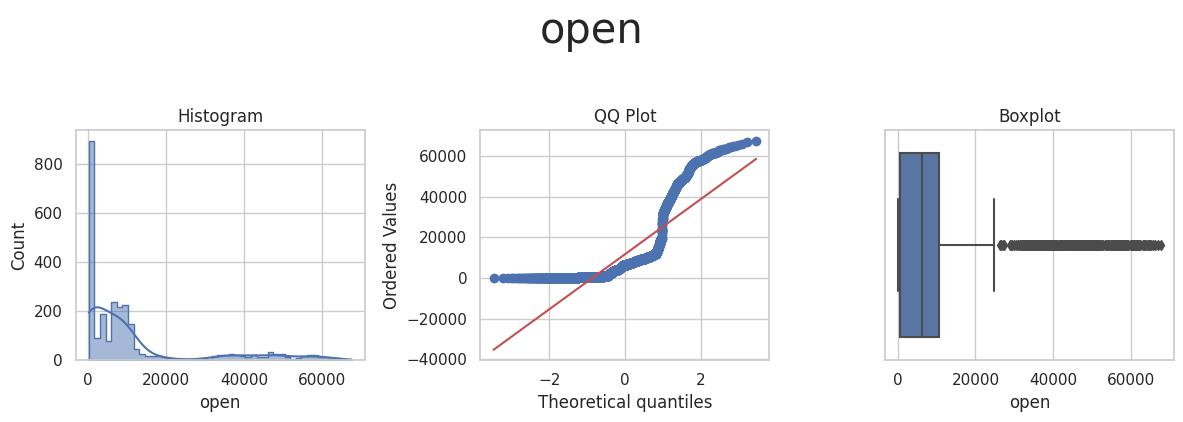

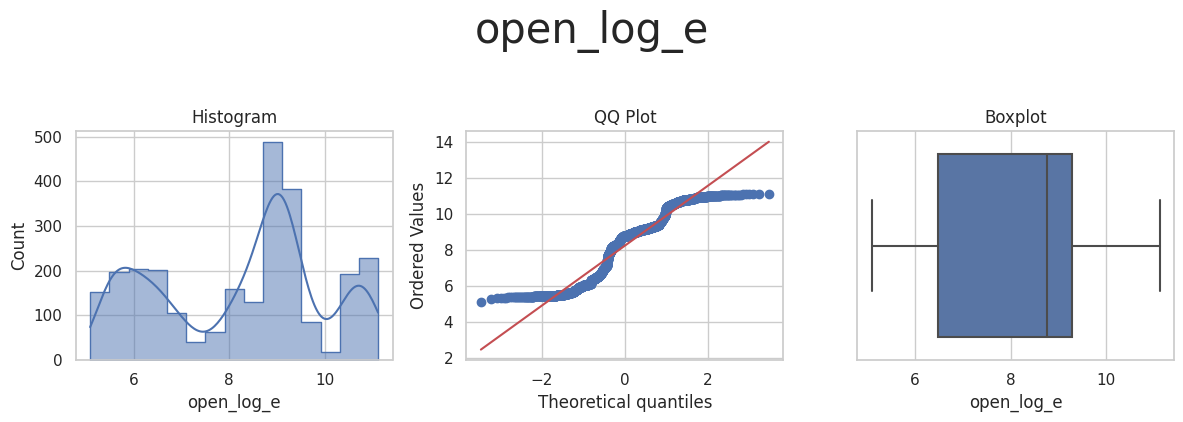

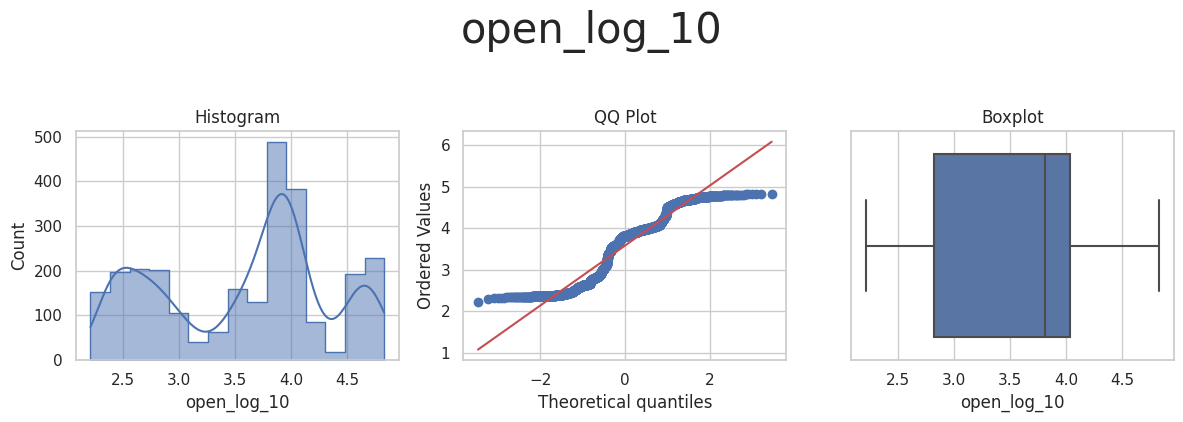

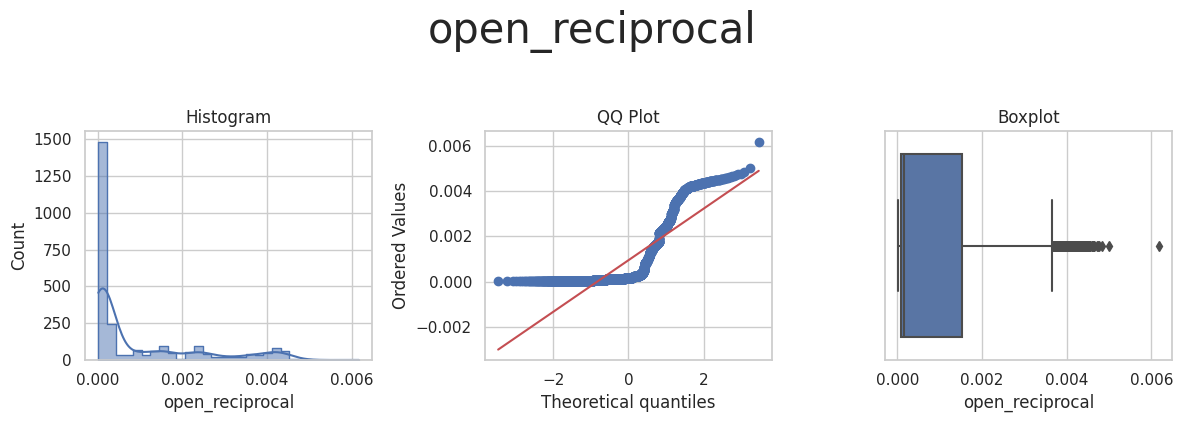

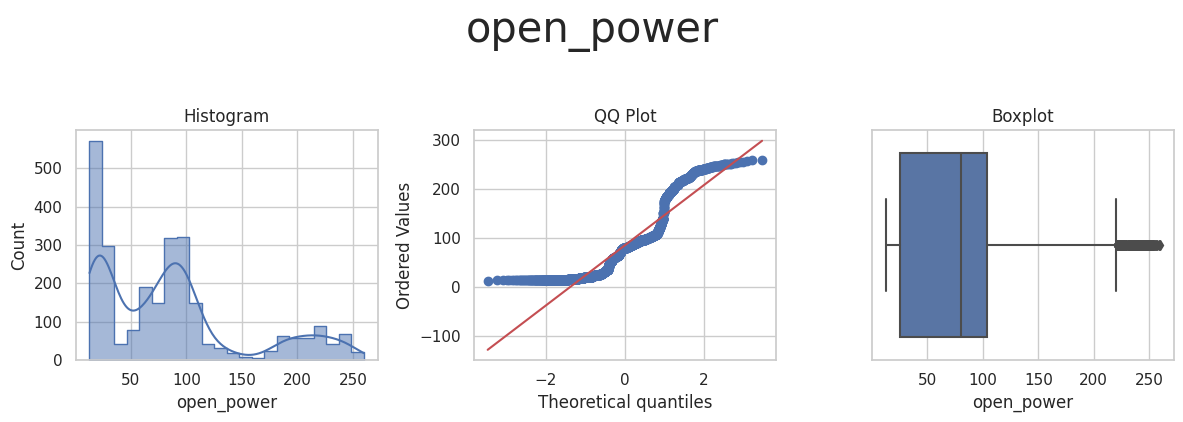

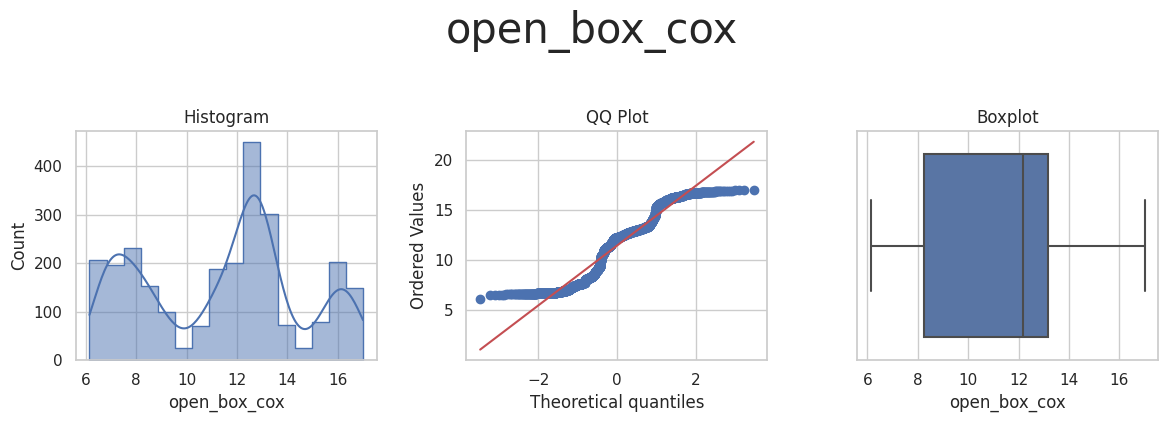

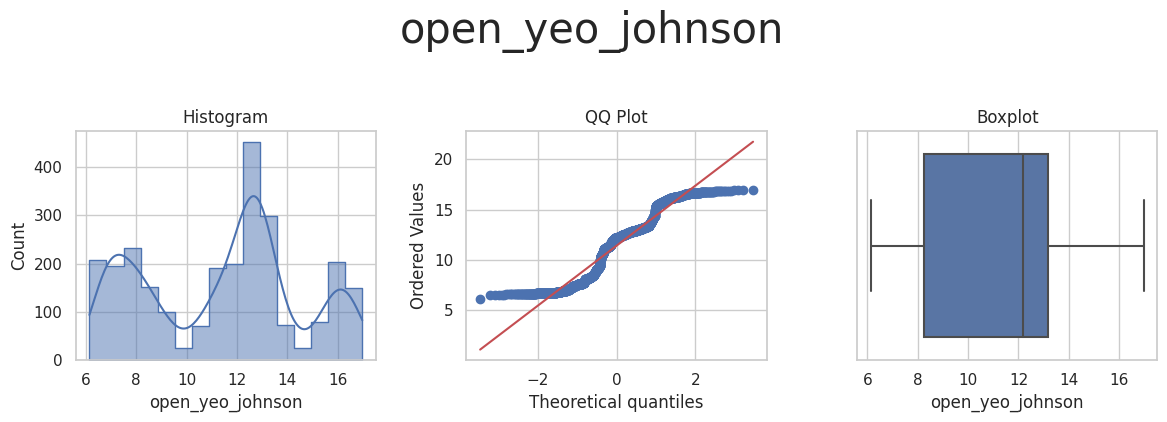



* Variable Analyzed: high
* Applied transformation: ['high_log_e', 'high_log_10', 'high_reciprocal', 'high_power', 'high_box_cox', 'high_yeo_johnson'] 



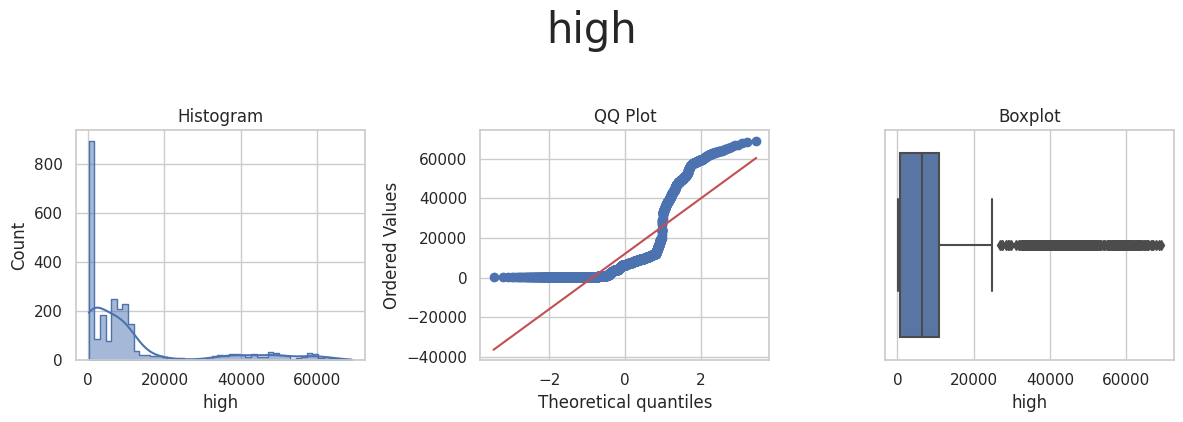

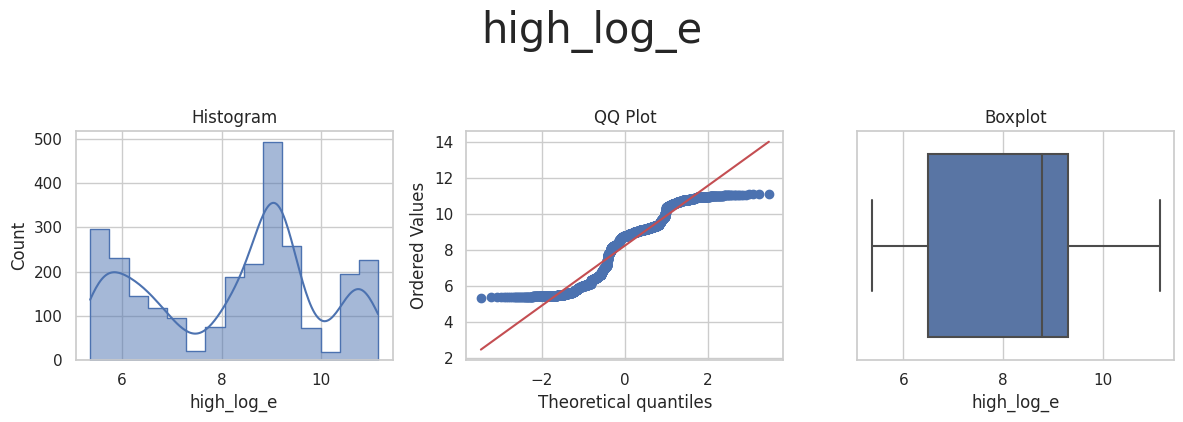

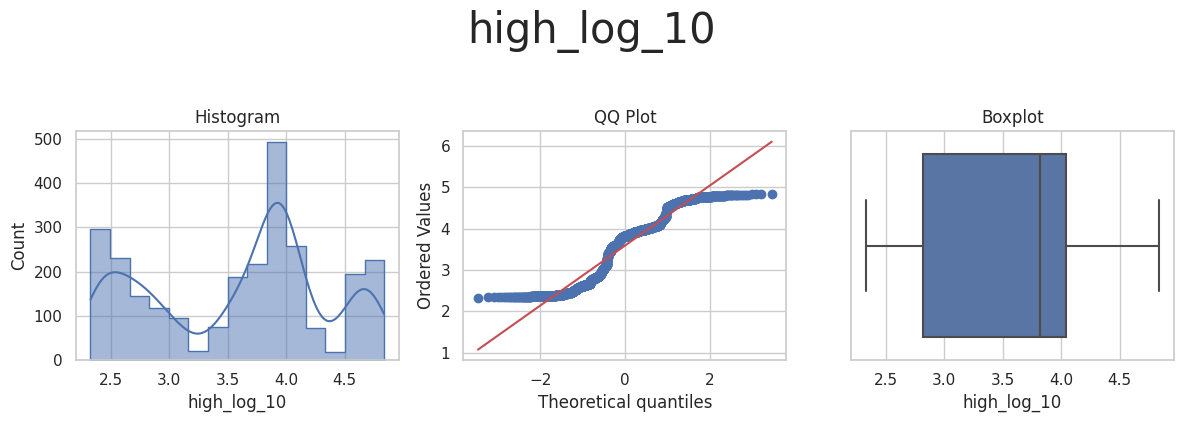

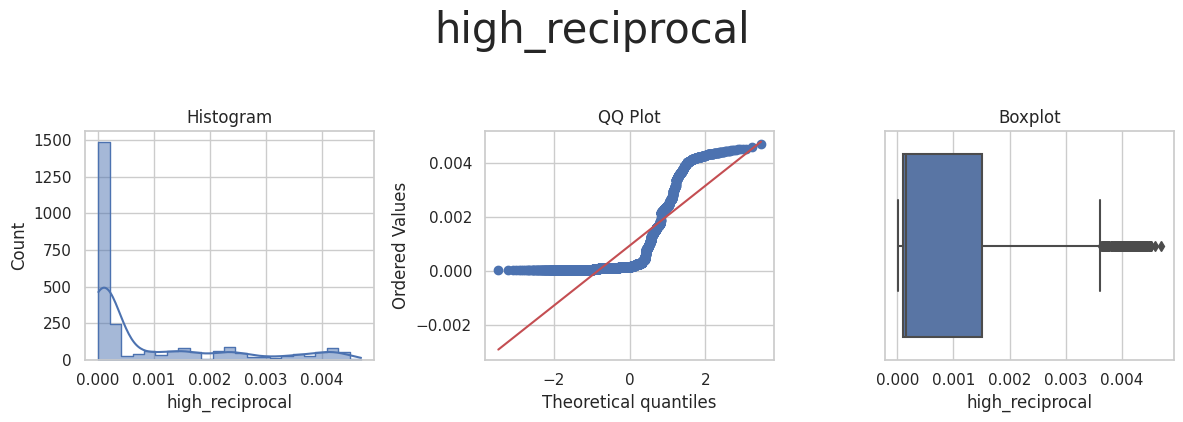

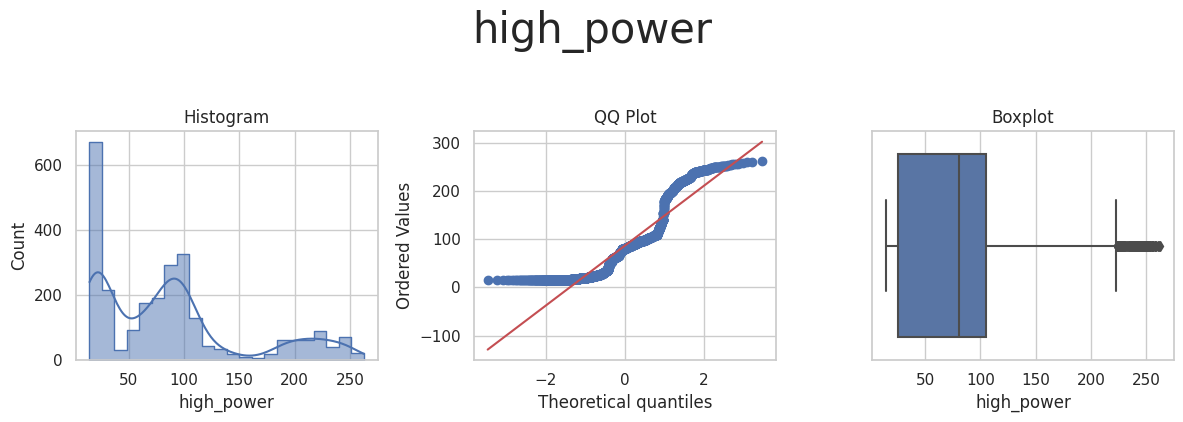

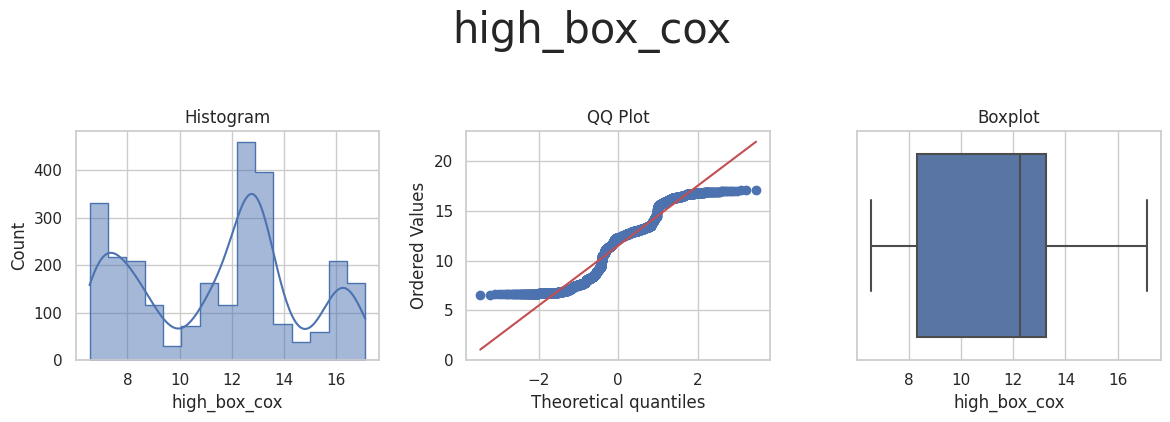

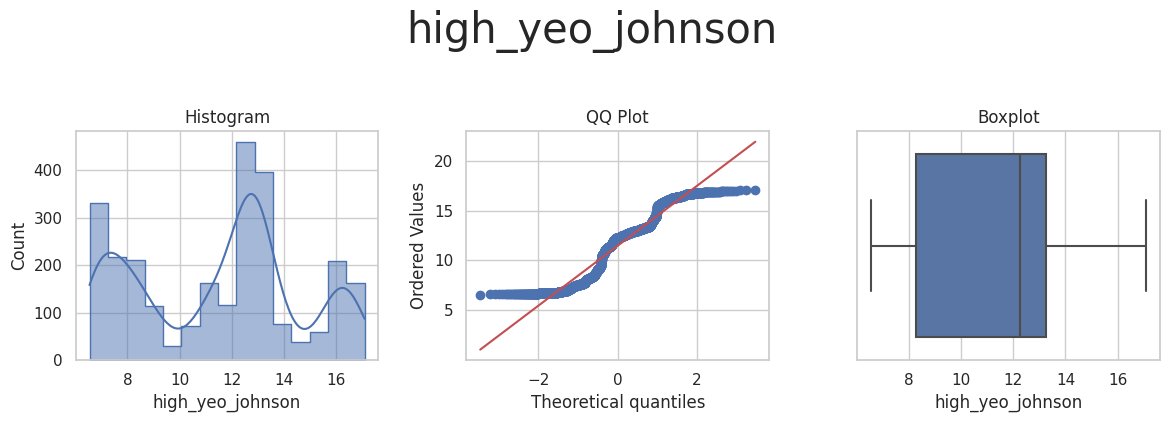



* Variable Analyzed: low
* Applied transformation: ['low_log_e', 'low_log_10', 'low_reciprocal', 'low_power', 'low_box_cox', 'low_yeo_johnson'] 



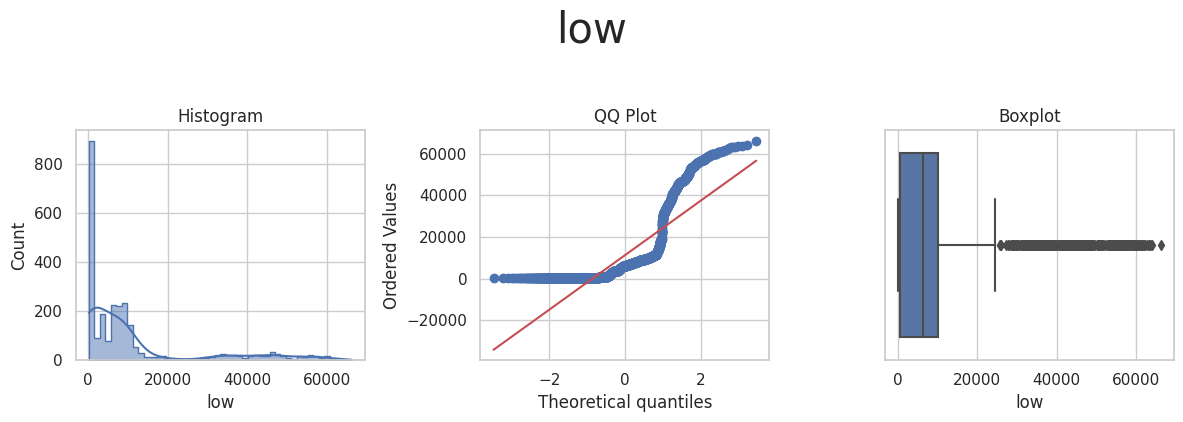

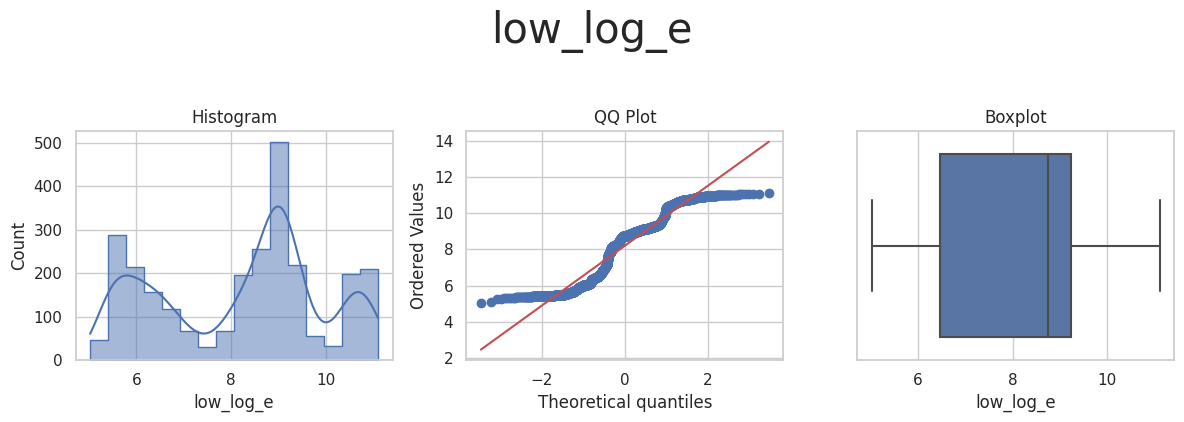

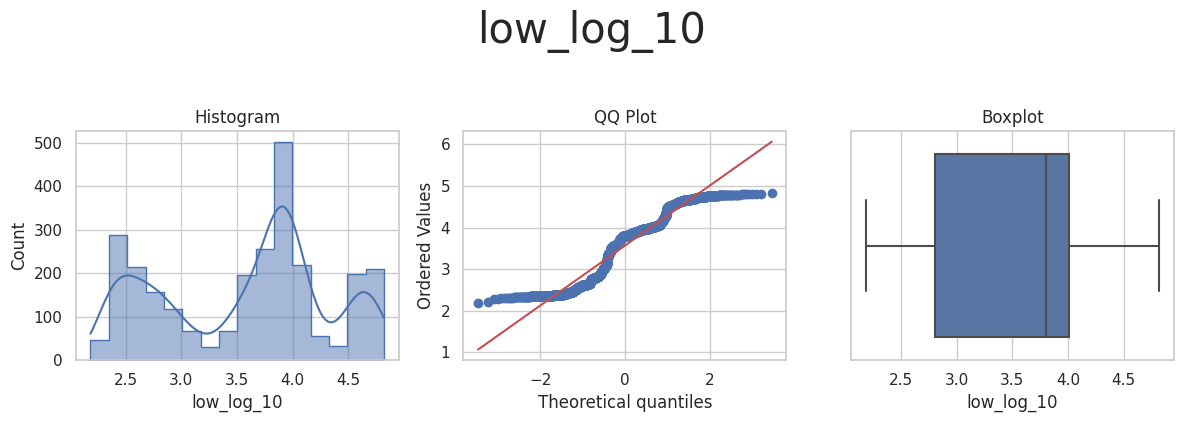

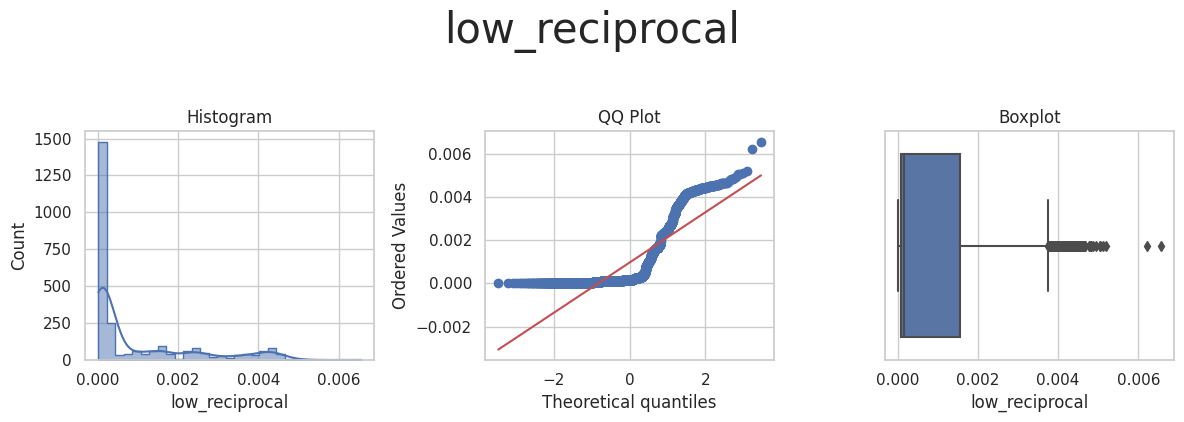

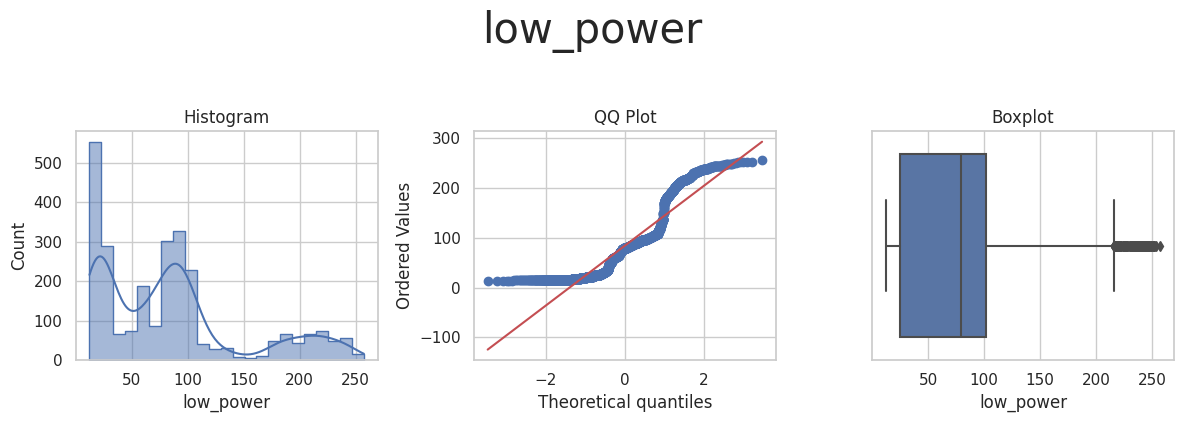

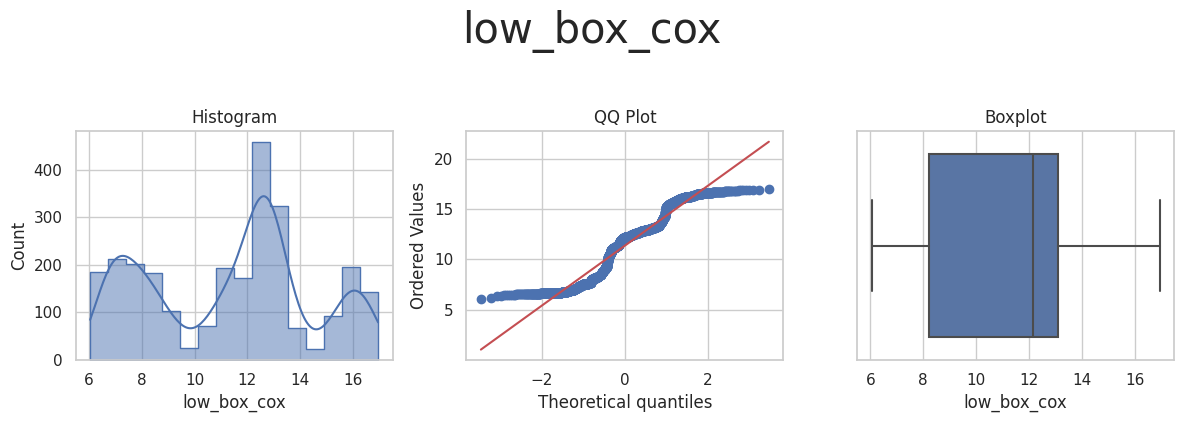

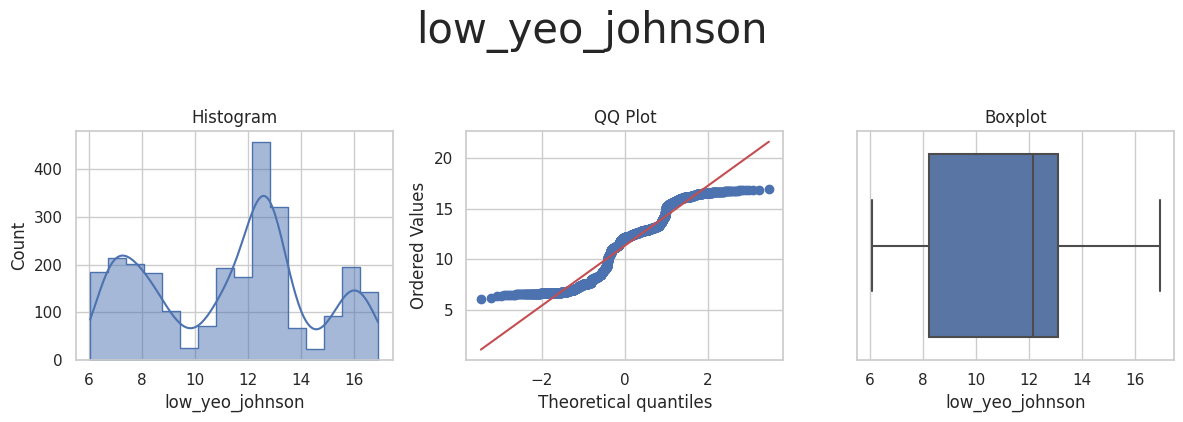



* Variable Analyzed: close
* Applied transformation: ['close_log_e', 'close_log_10', 'close_reciprocal', 'close_power', 'close_box_cox', 'close_yeo_johnson'] 



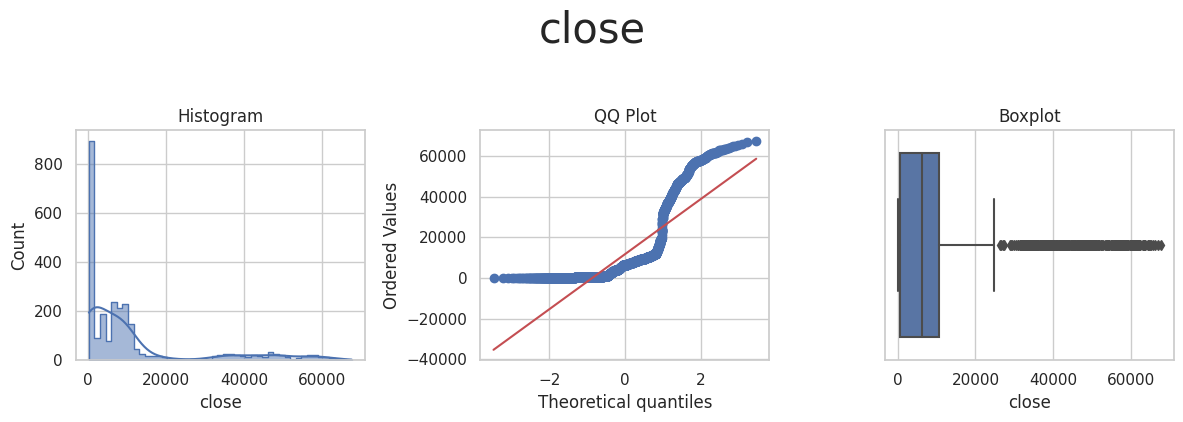

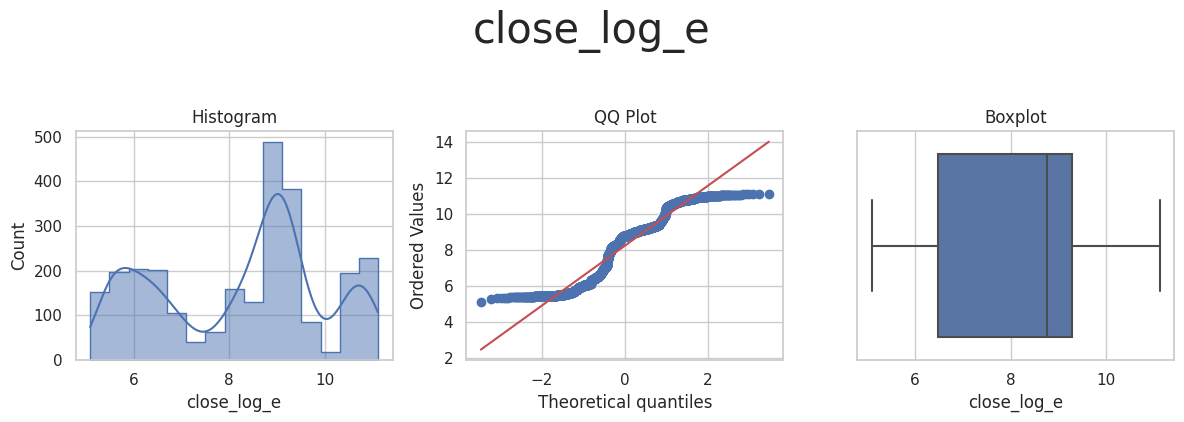

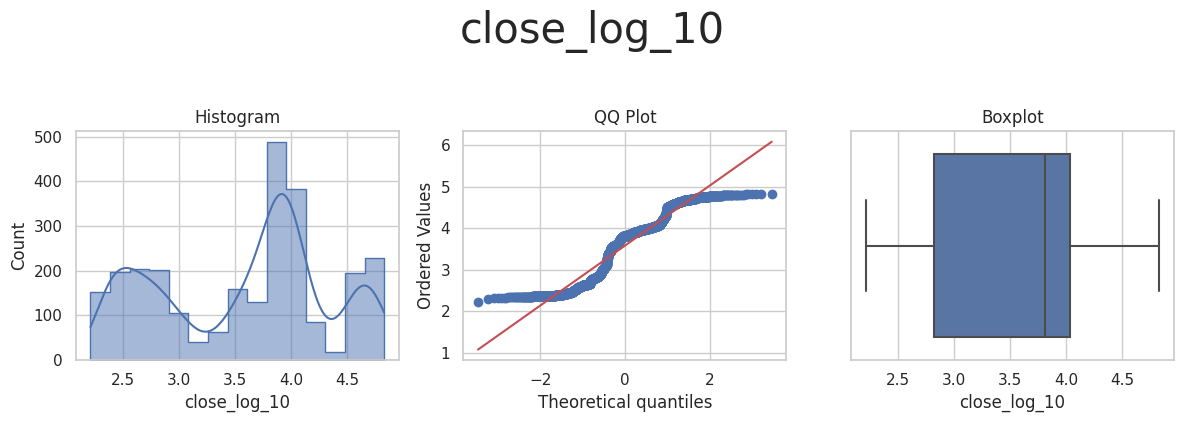

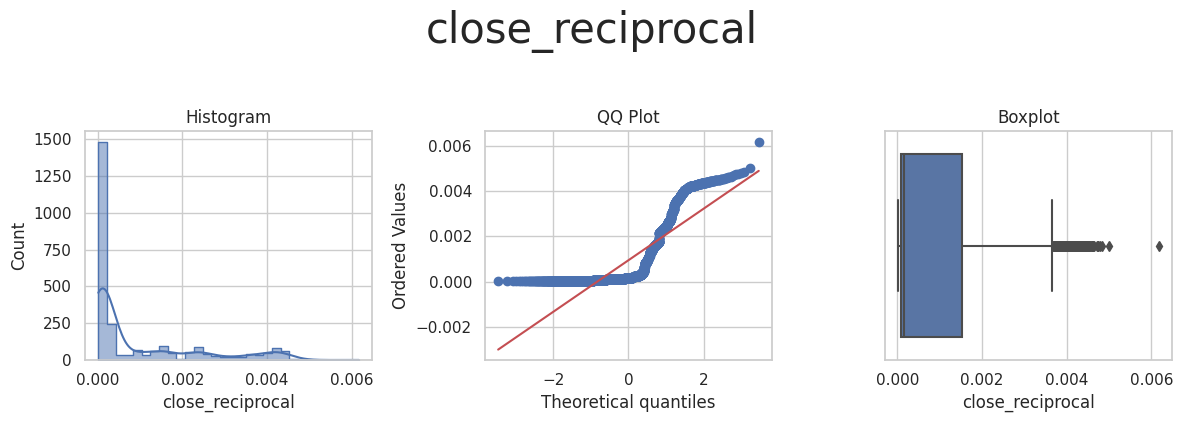

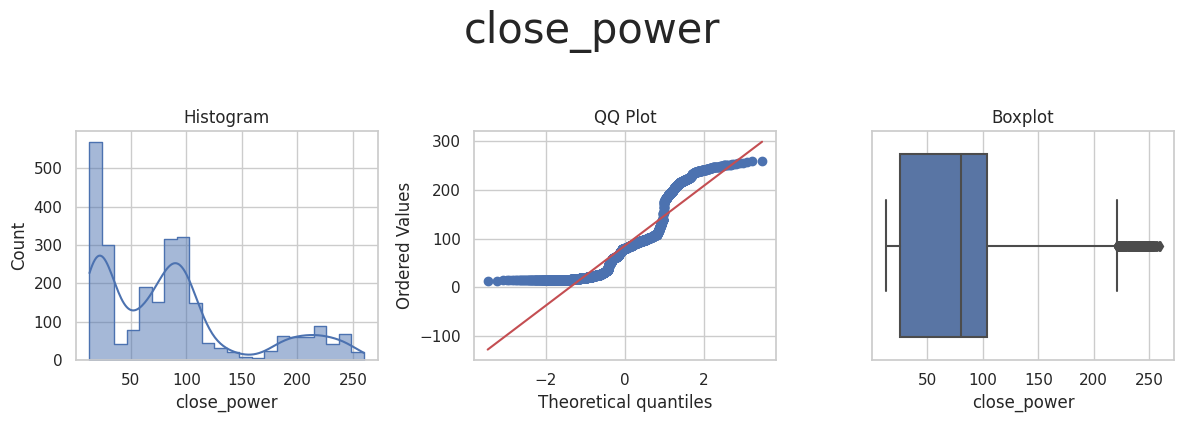

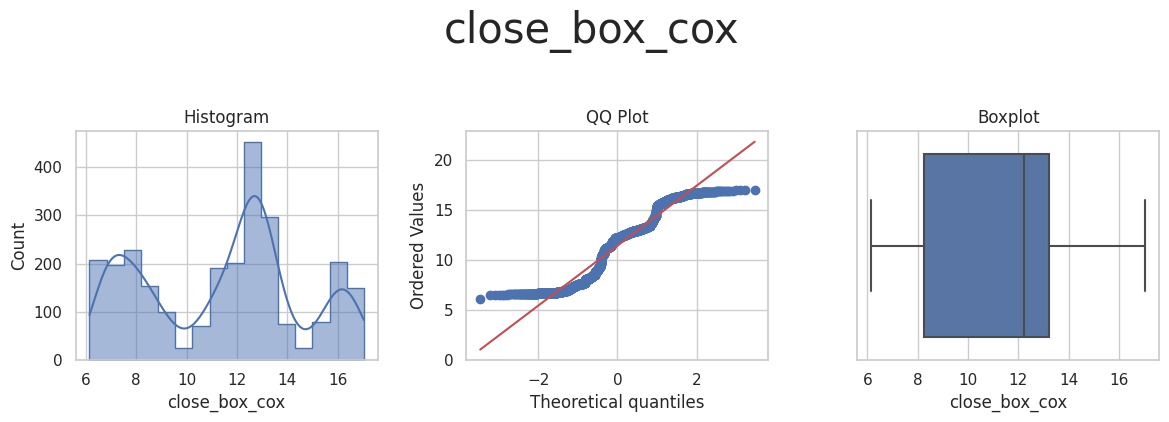

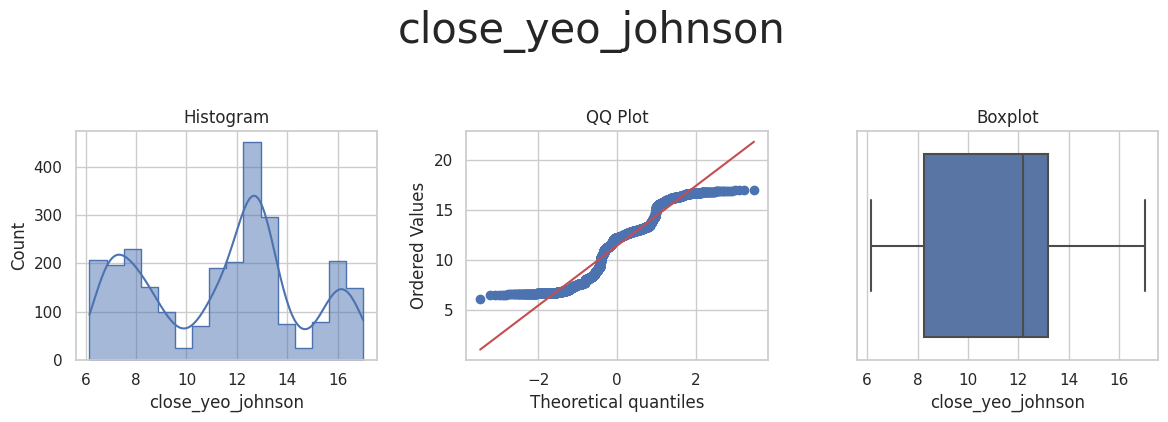



* Variable Analyzed: Volume BTC
* Applied transformation: ['Volume BTC_power', 'Volume BTC_yeo_johnson'] 



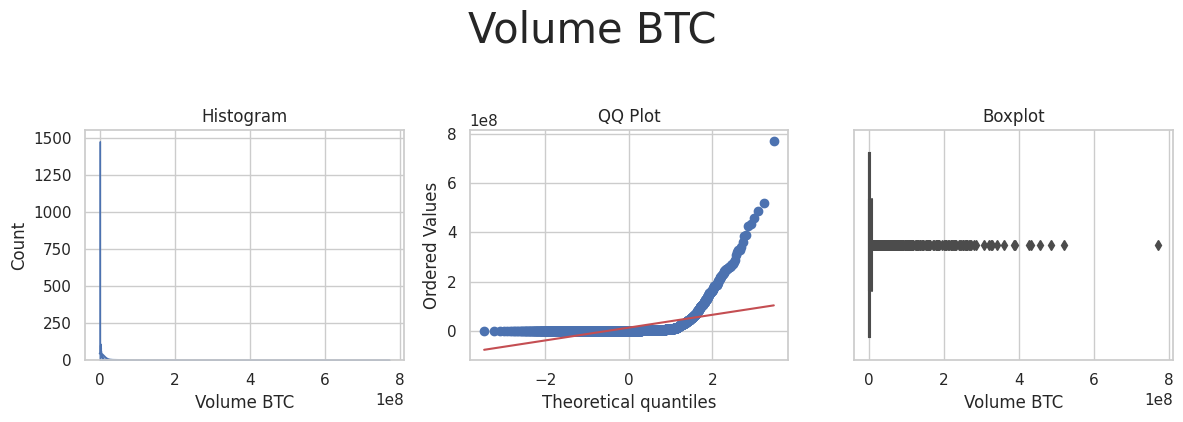

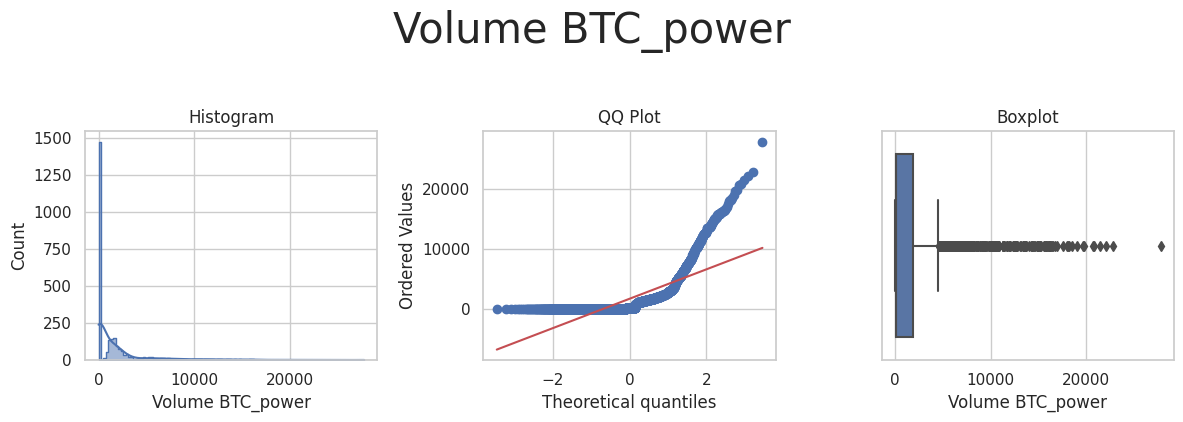

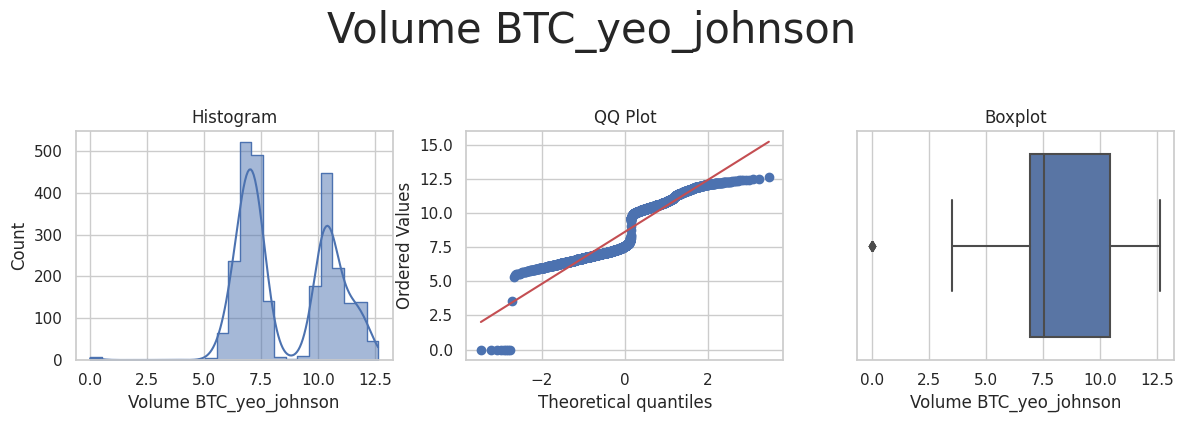



* Variable Analyzed: Volume USD
* Applied transformation: ['Volume USD_power', 'Volume USD_yeo_johnson'] 



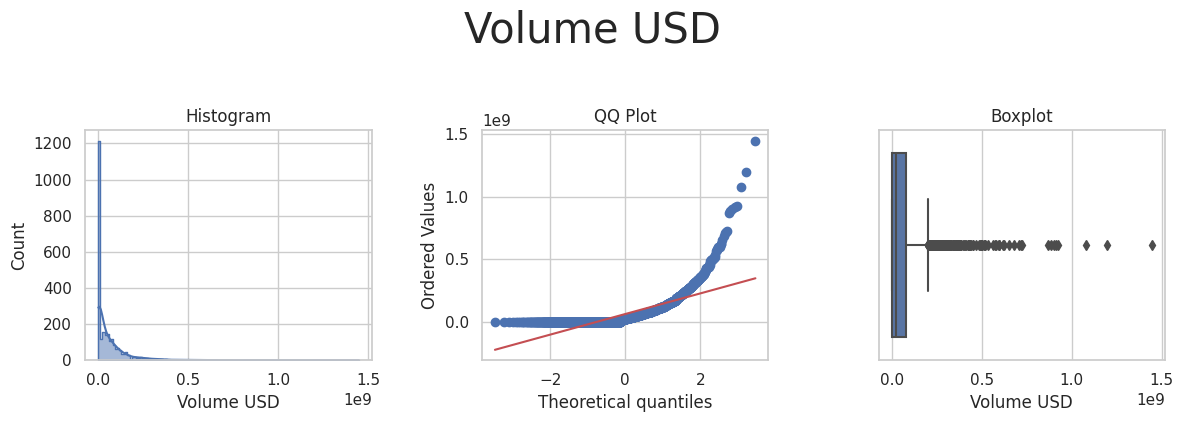

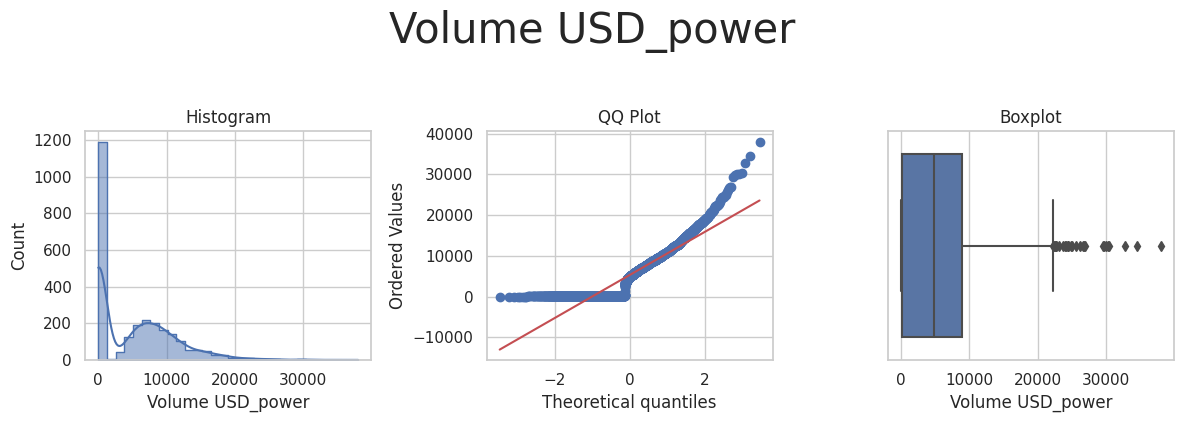

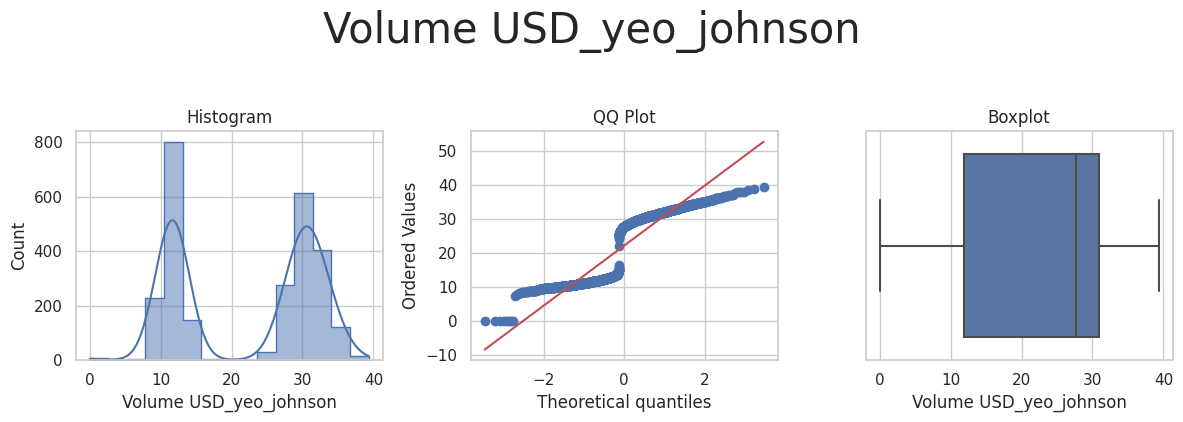



* Variable Analyzed: price mean
* Applied transformation: ['price mean_log_e', 'price mean_log_10', 'price mean_reciprocal', 'price mean_power', 'price mean_box_cox', 'price mean_yeo_johnson'] 



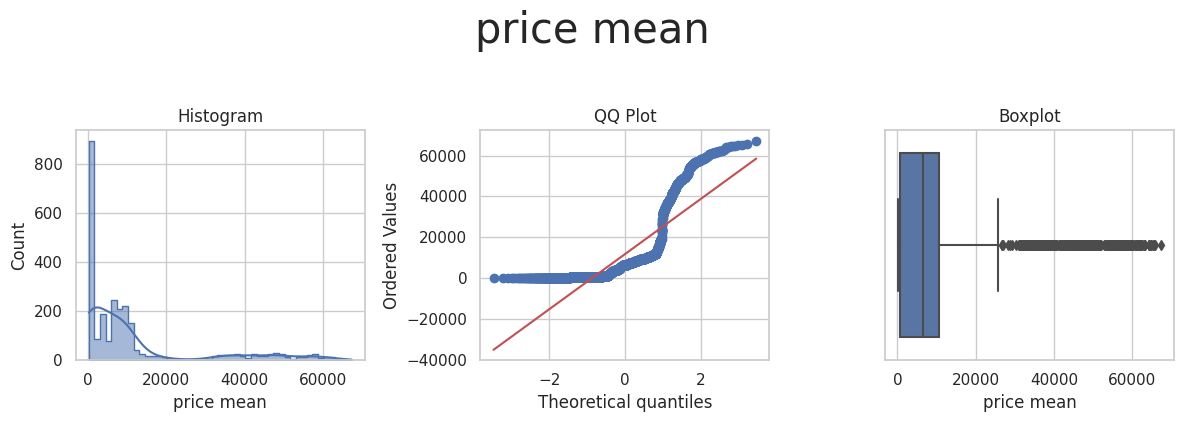

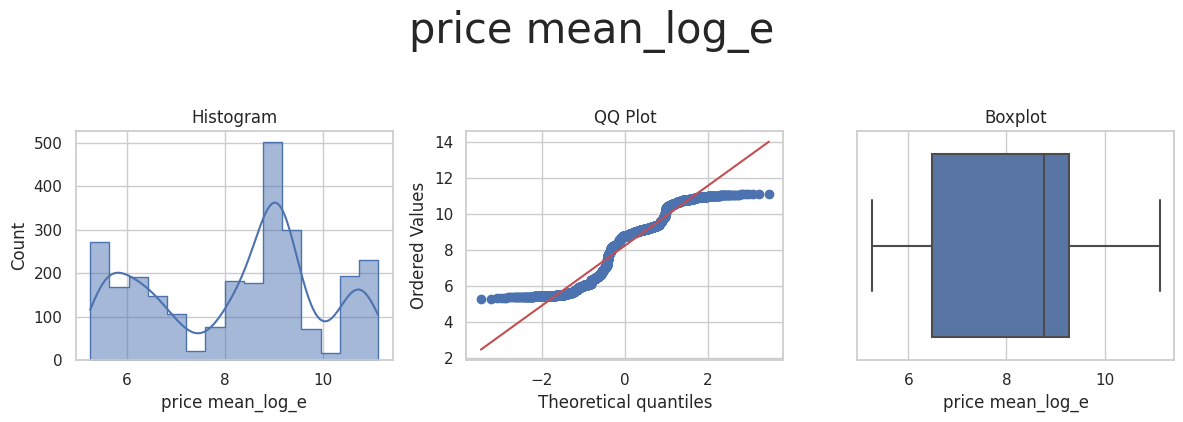

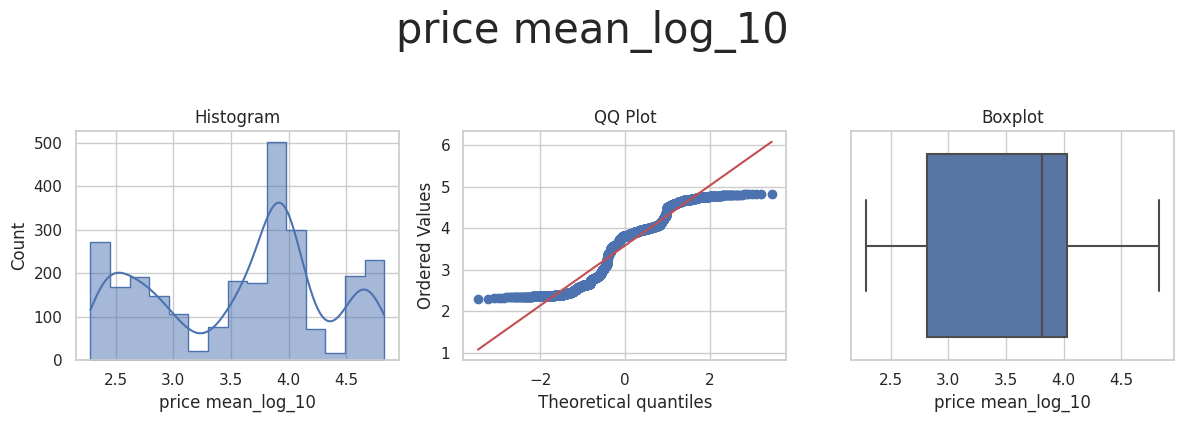

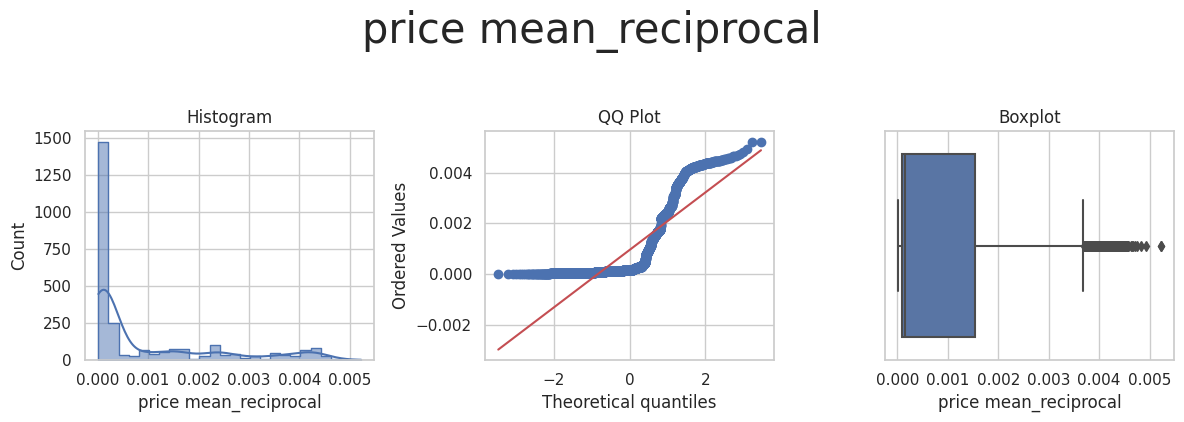

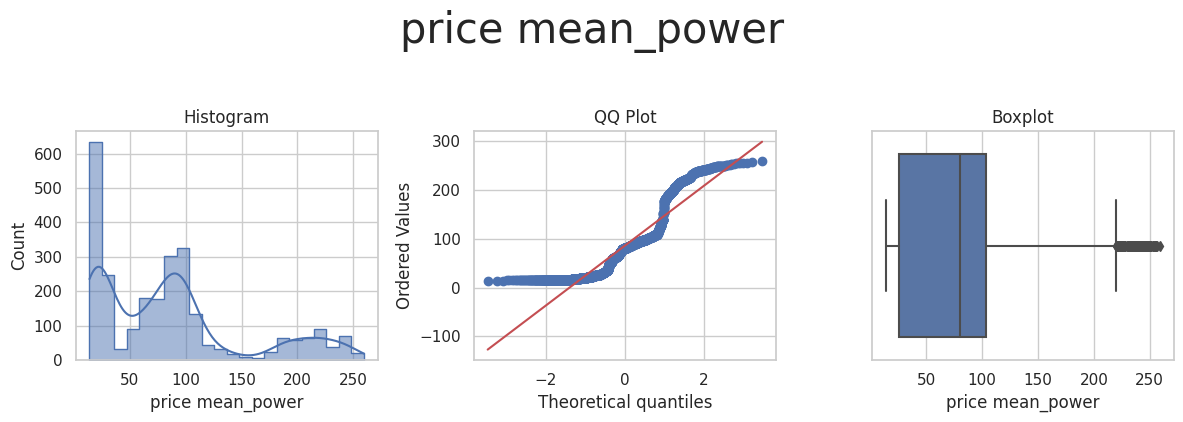

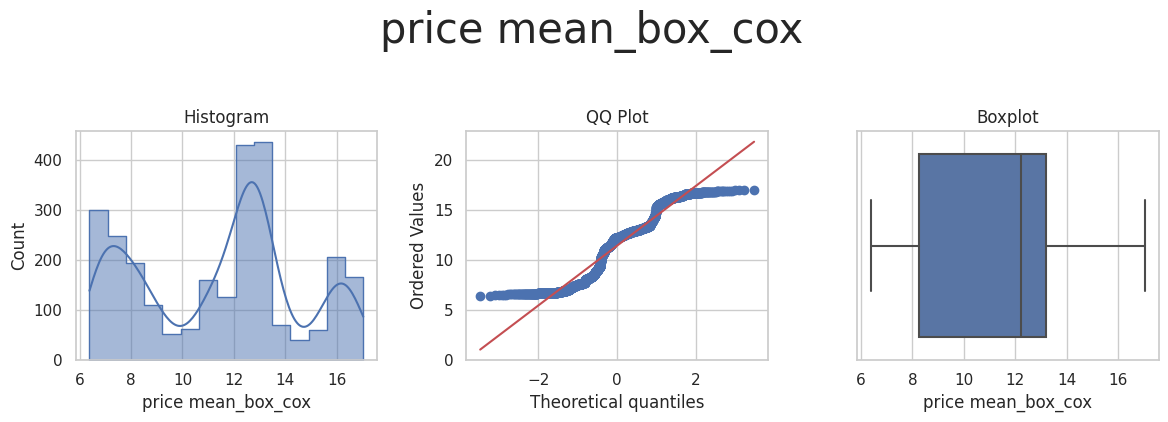

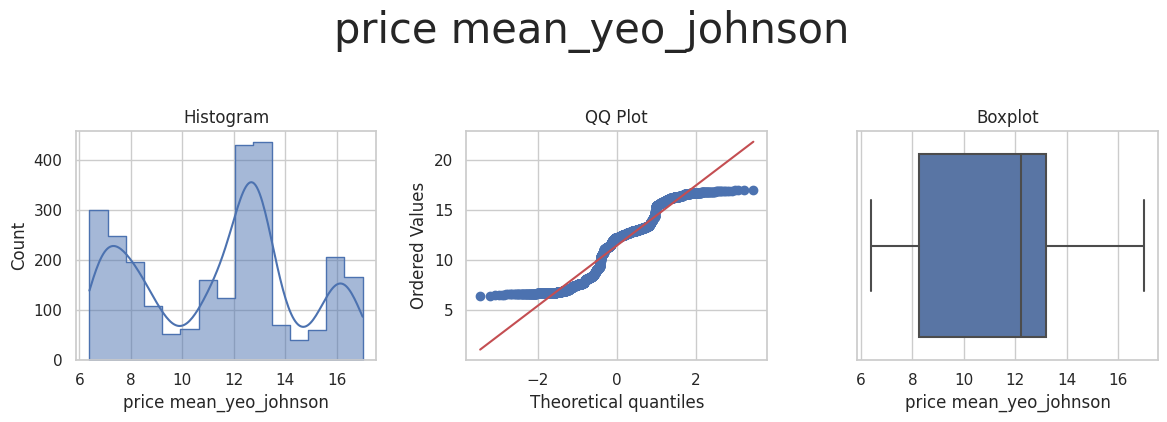



* Variable Analyzed: upper shadow
* Applied transformation: ['upper shadow_power', 'upper shadow_yeo_johnson'] 



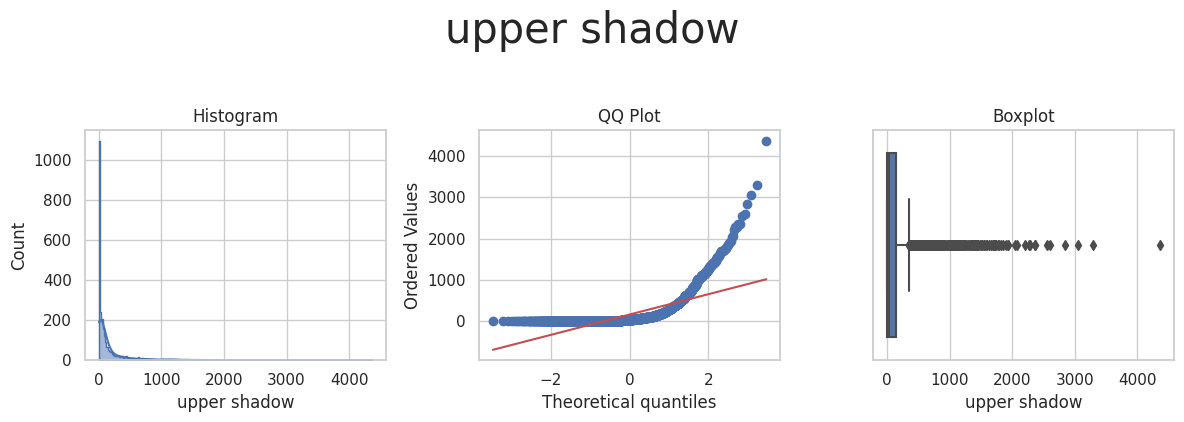

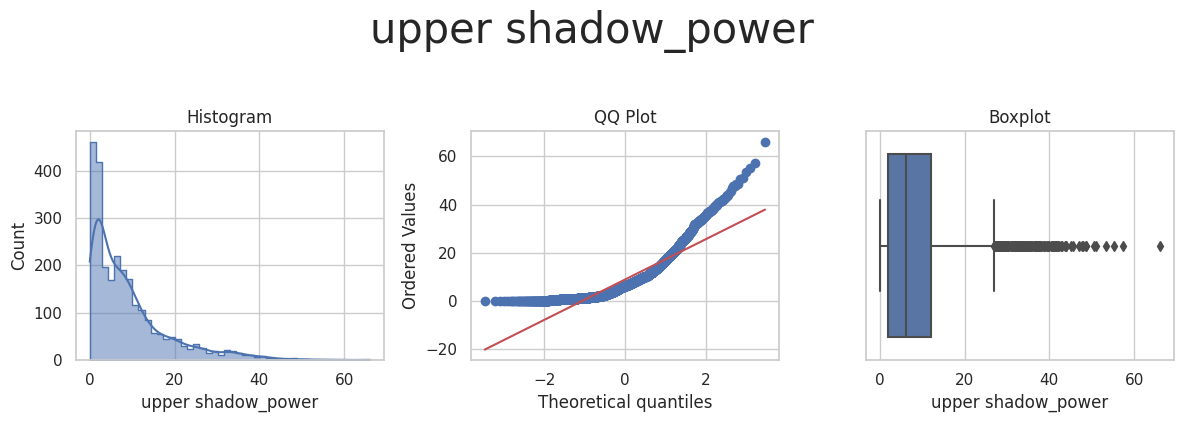

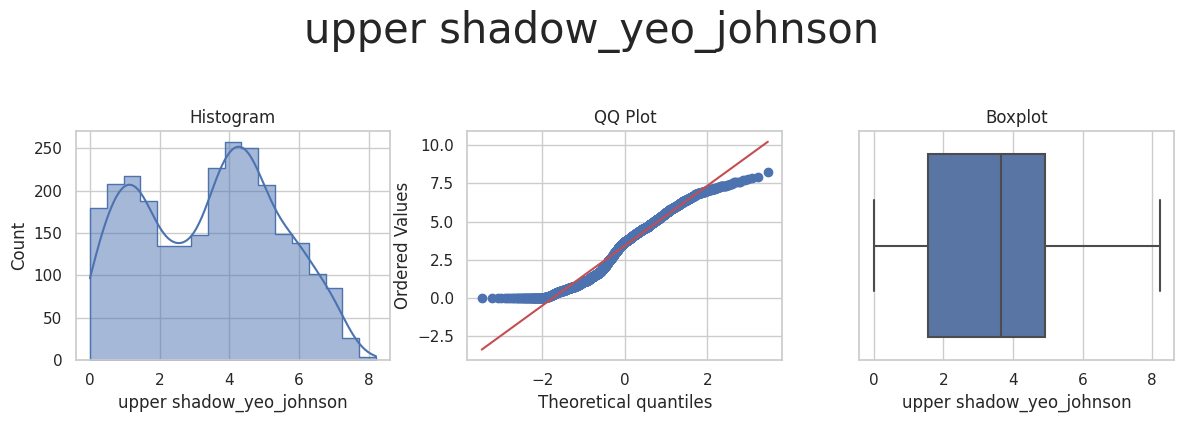



* Variable Analyzed: lower shadow
* Applied transformation: ['lower shadow_power', 'lower shadow_yeo_johnson'] 



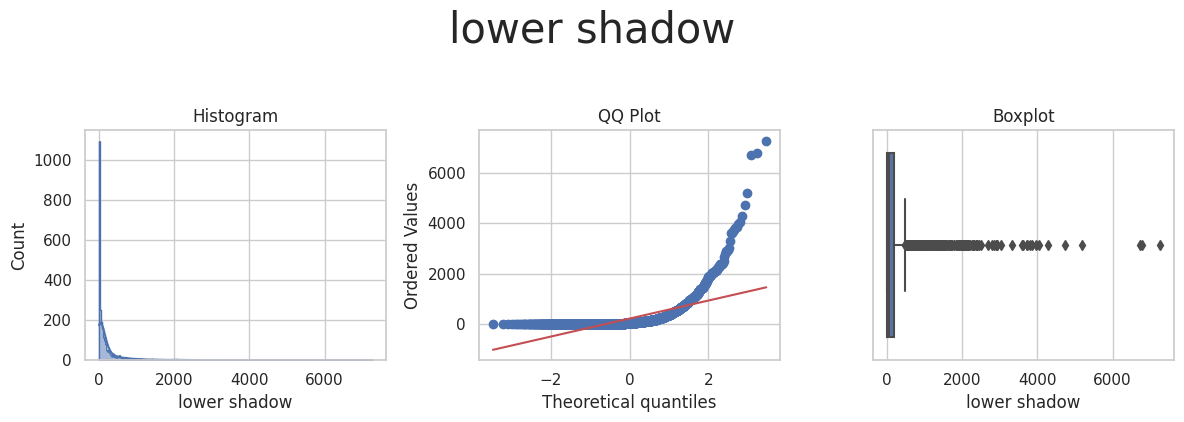

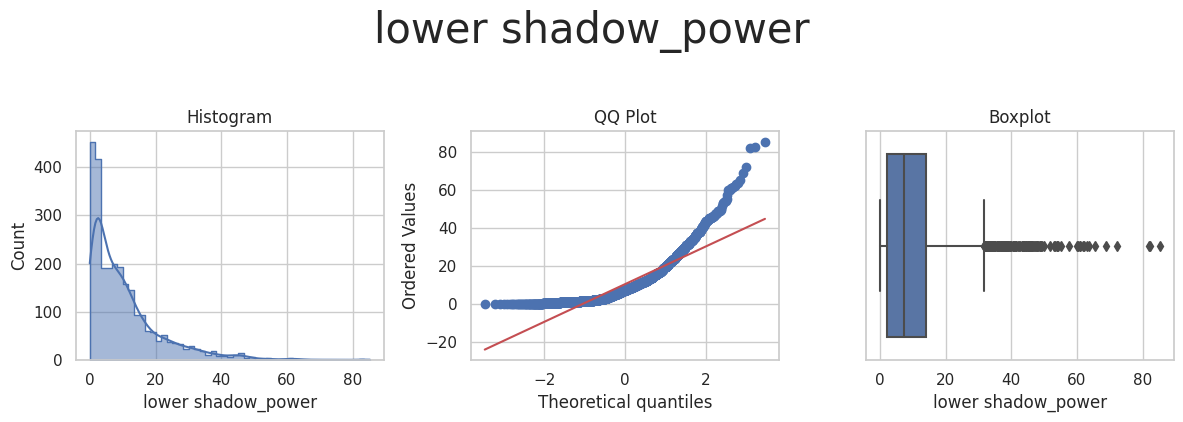

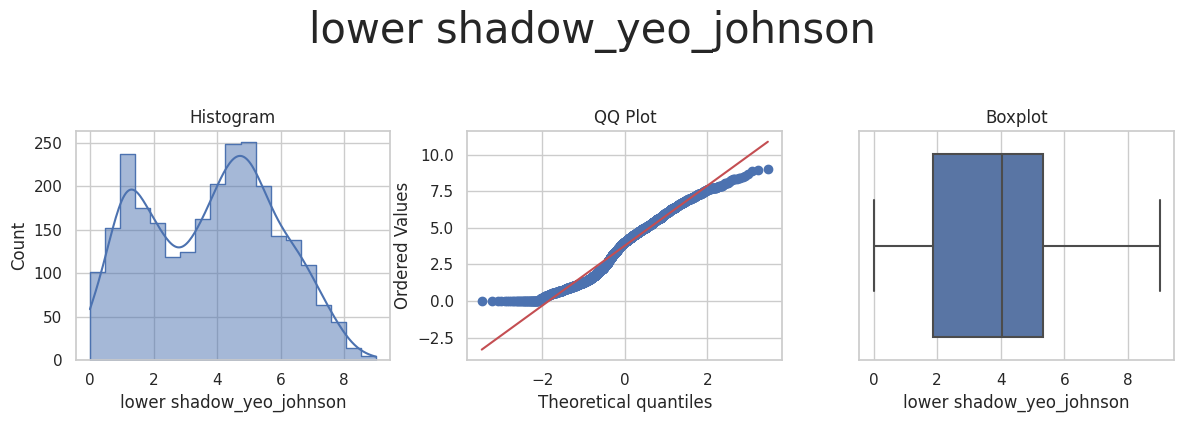



* Variable Analyzed: spread
* Applied transformation: ['spread_power', 'spread_yeo_johnson'] 



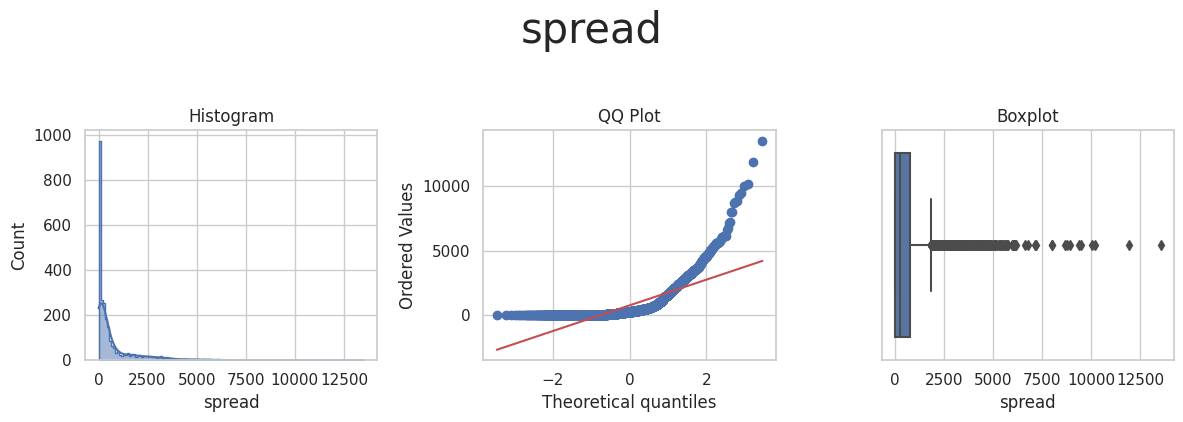

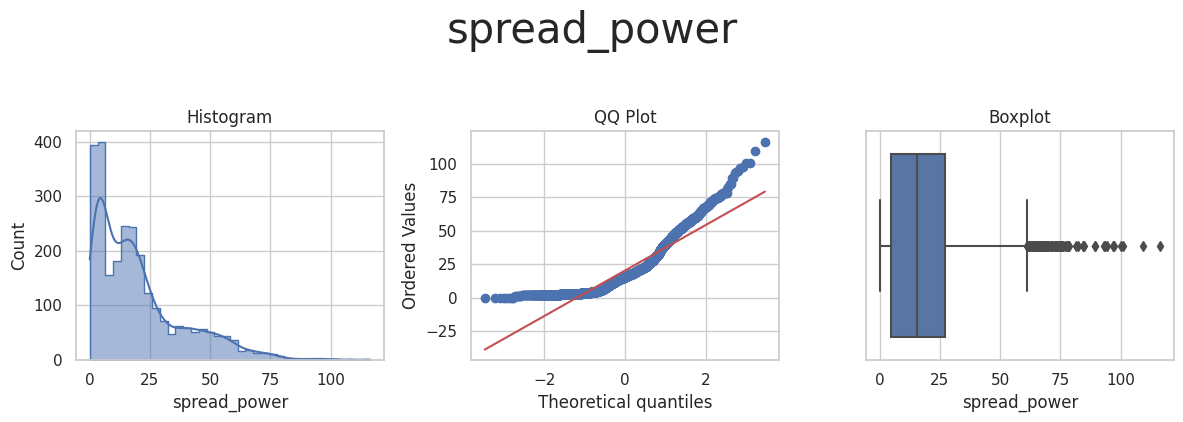

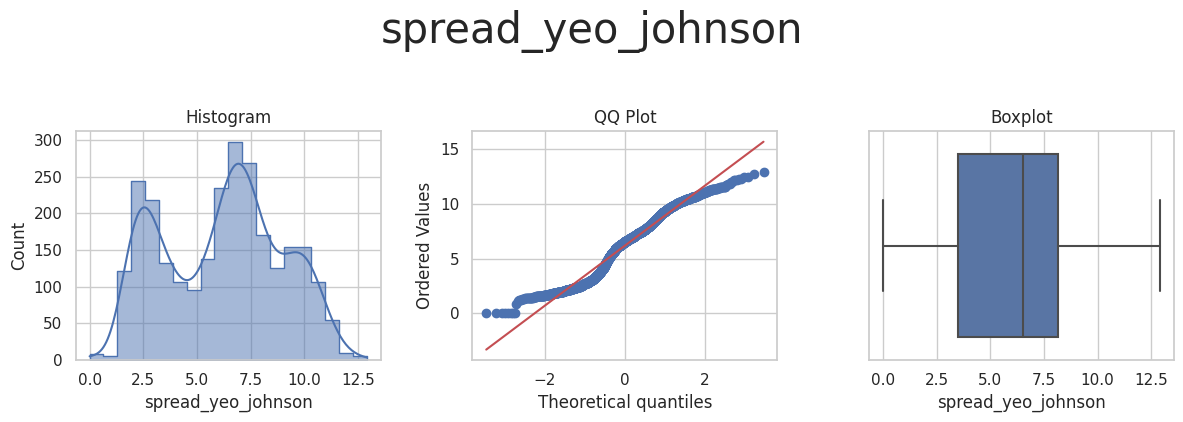



* Variable Analyzed: trade
* Applied transformation: ['trade_power', 'trade_yeo_johnson'] 



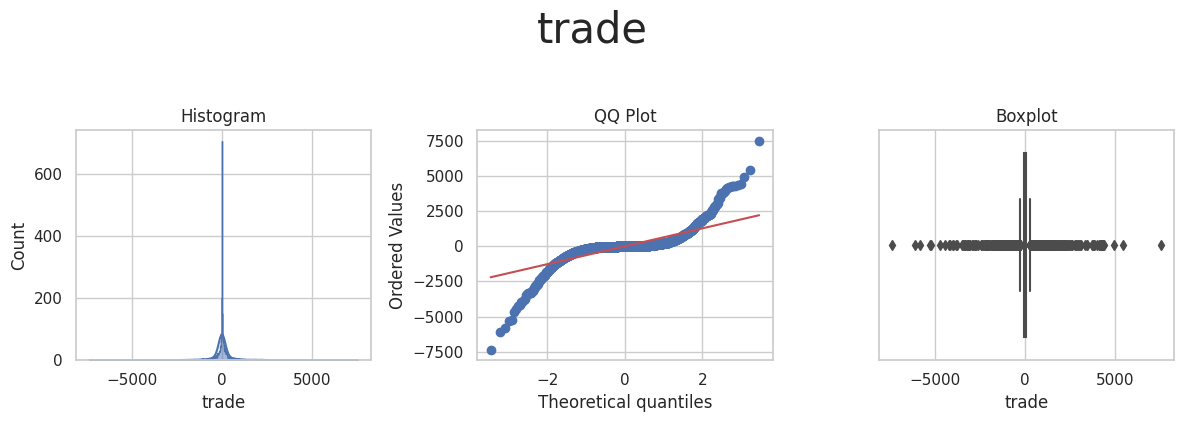

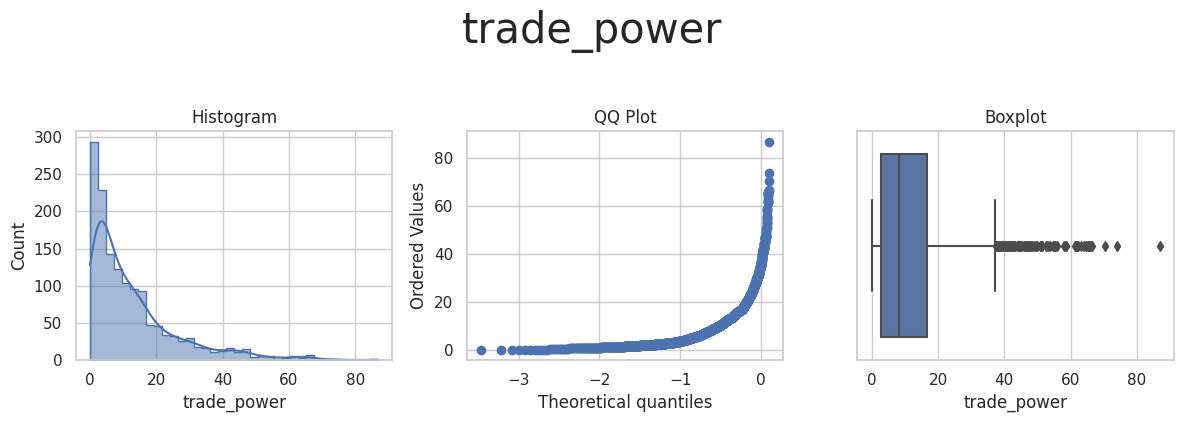

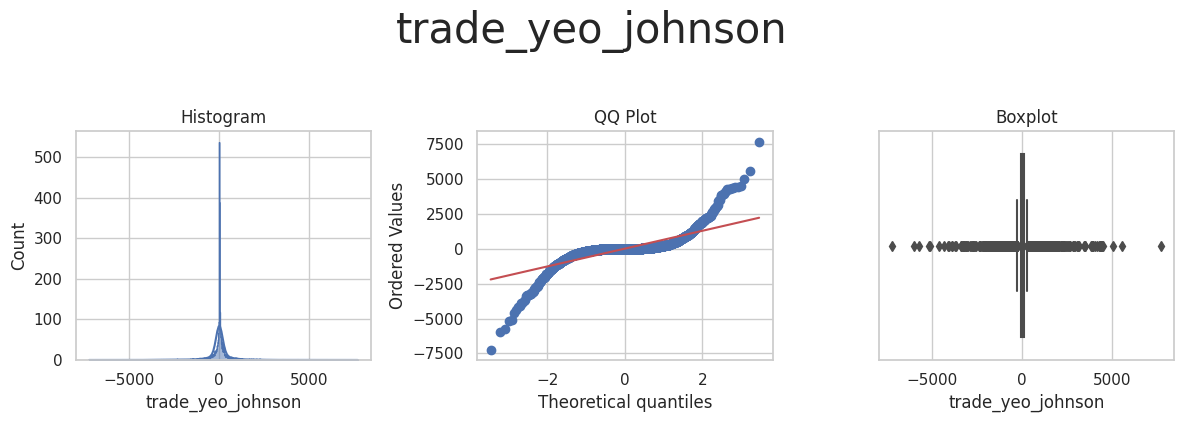



* Variable Analyzed: 12EMA
* Applied transformation: ['12EMA_log_e', '12EMA_log_10', '12EMA_reciprocal', '12EMA_power', '12EMA_box_cox', '12EMA_yeo_johnson'] 



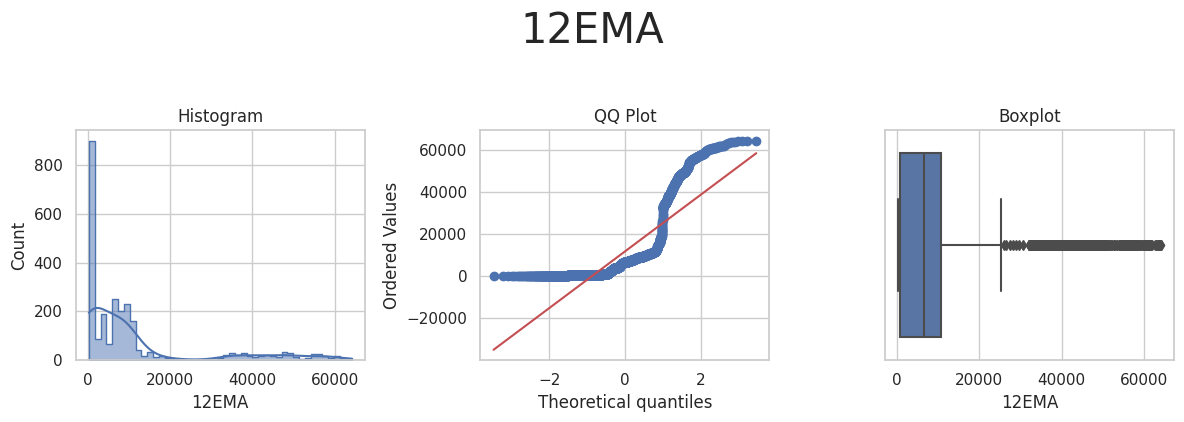

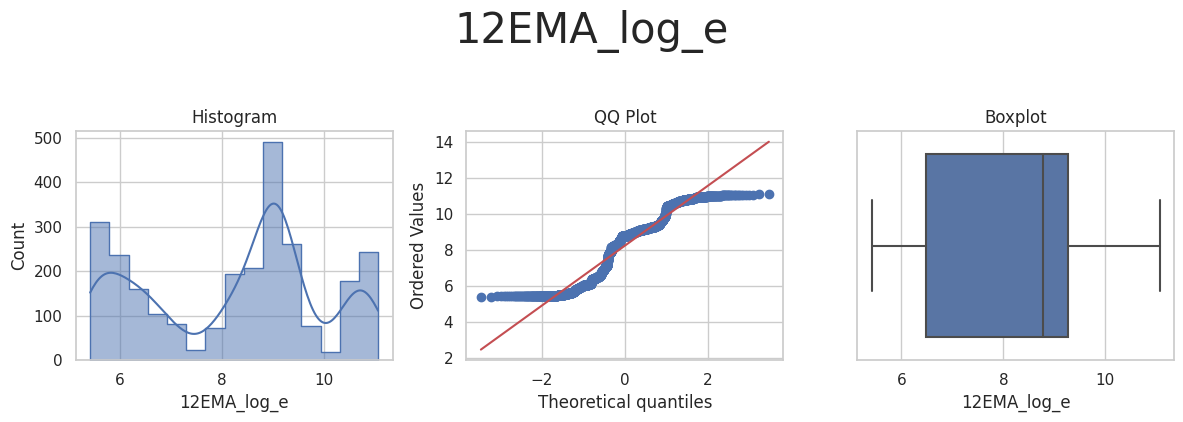

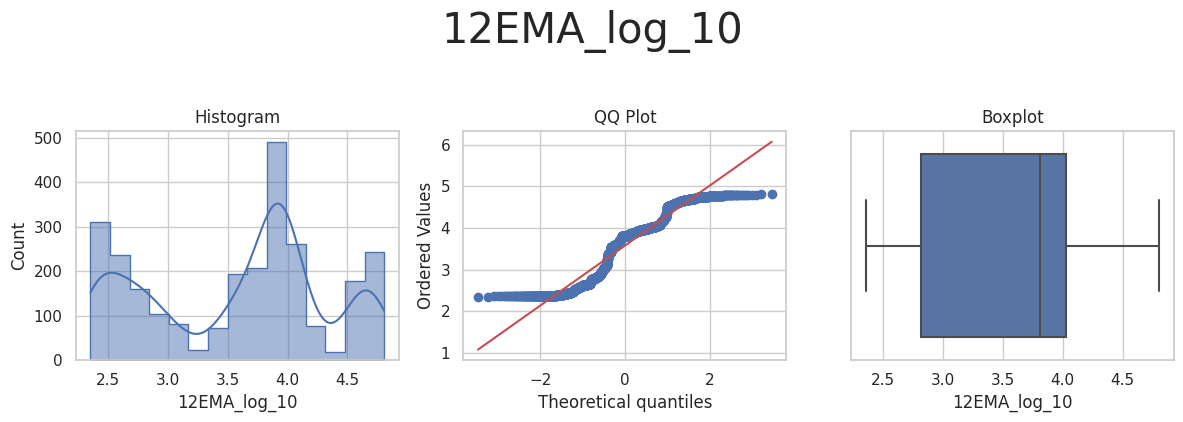

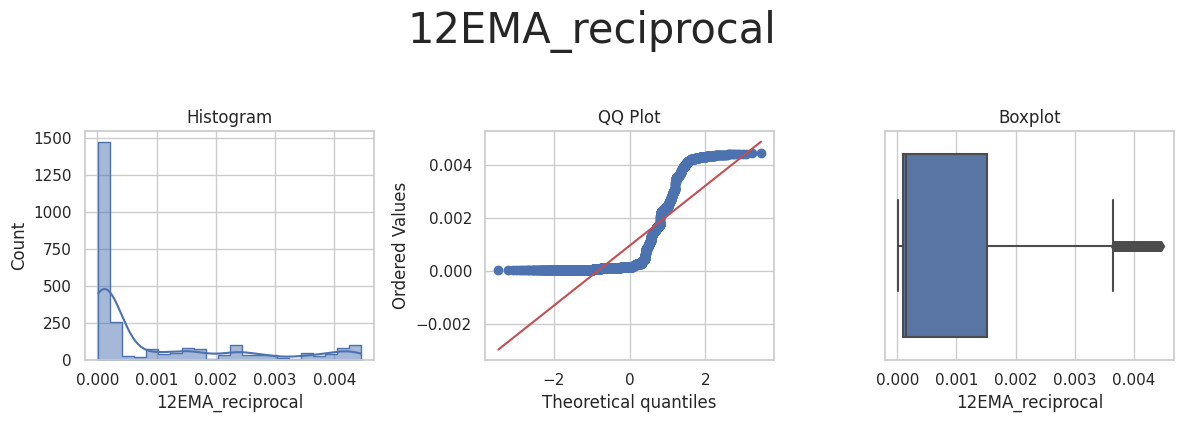

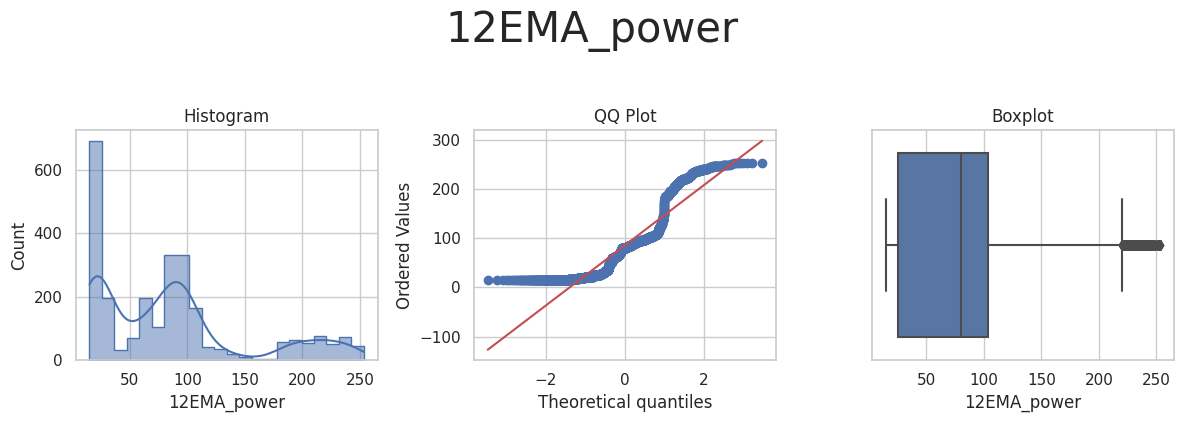

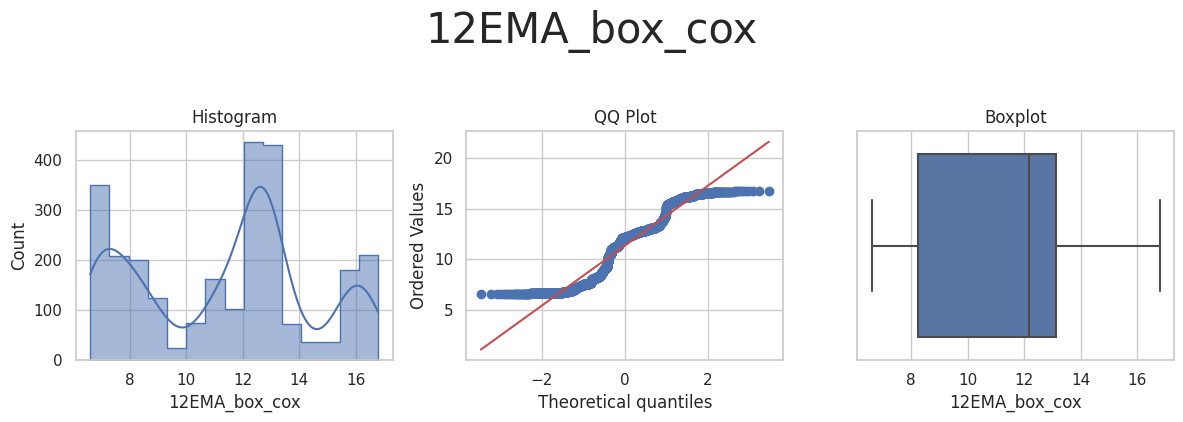

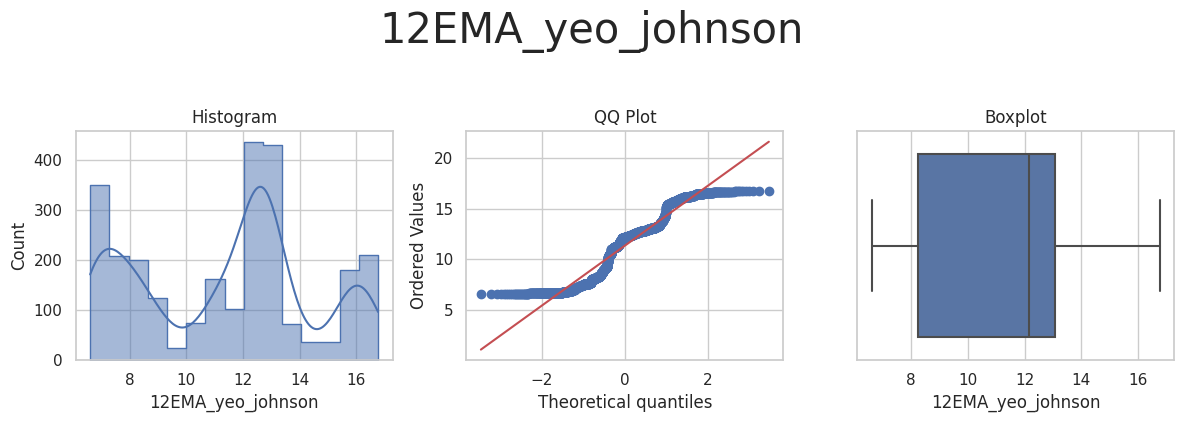



* Variable Analyzed: 26EMA
* Applied transformation: ['26EMA_log_e', '26EMA_log_10', '26EMA_reciprocal', '26EMA_power', '26EMA_box_cox', '26EMA_yeo_johnson'] 



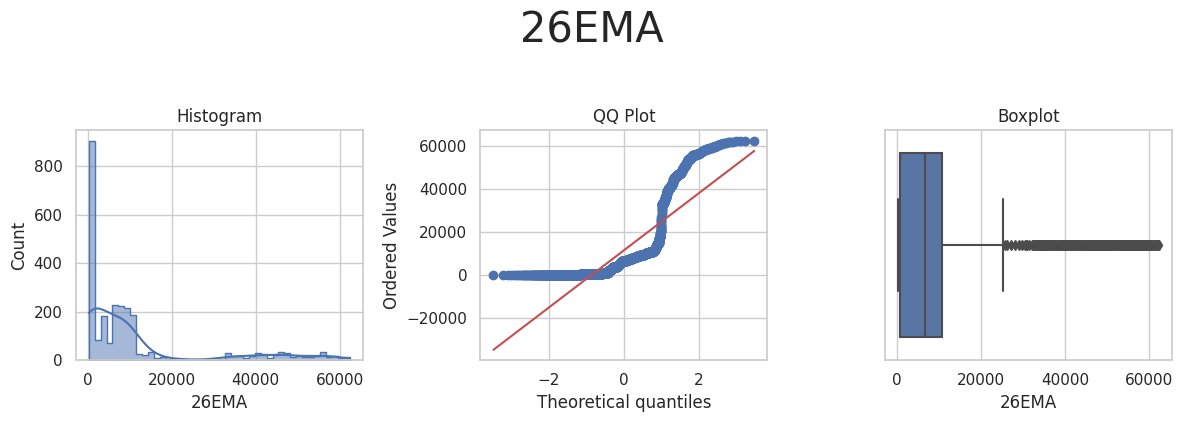

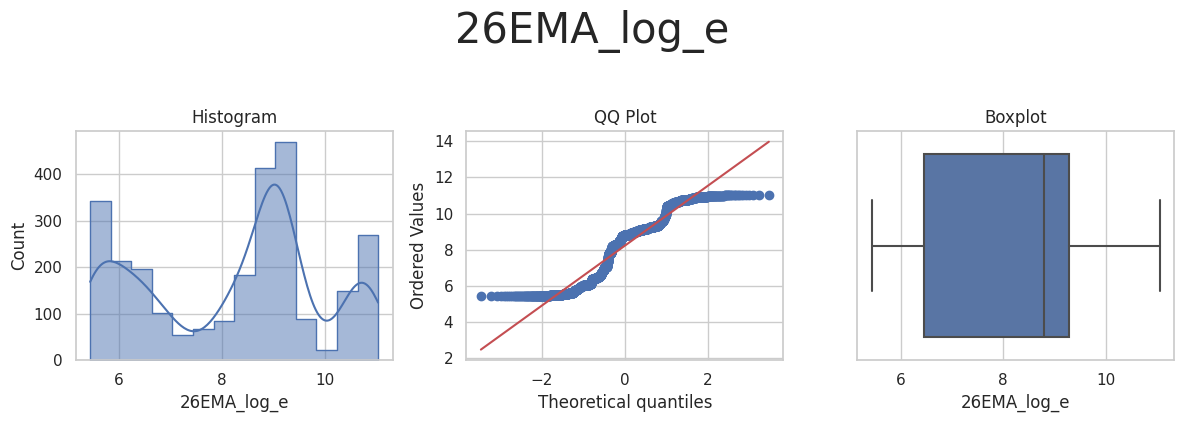

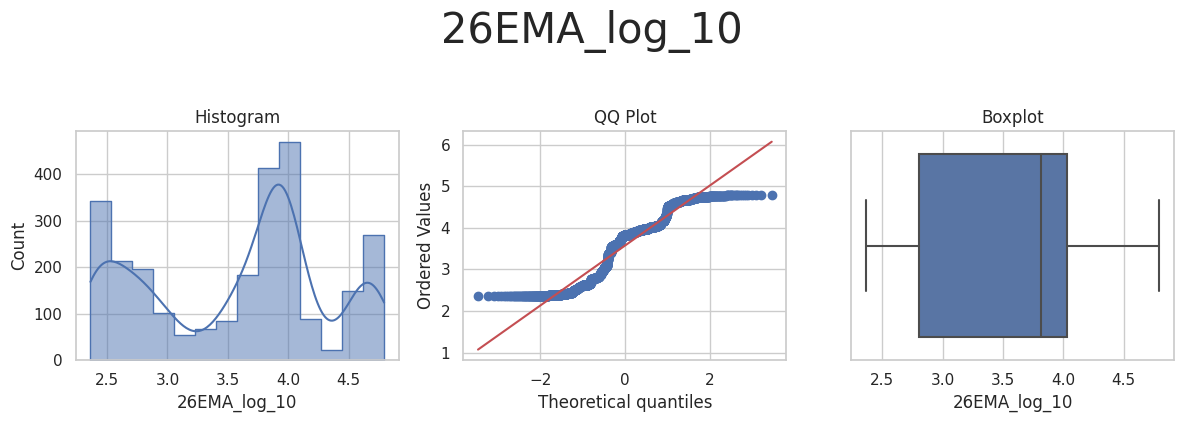

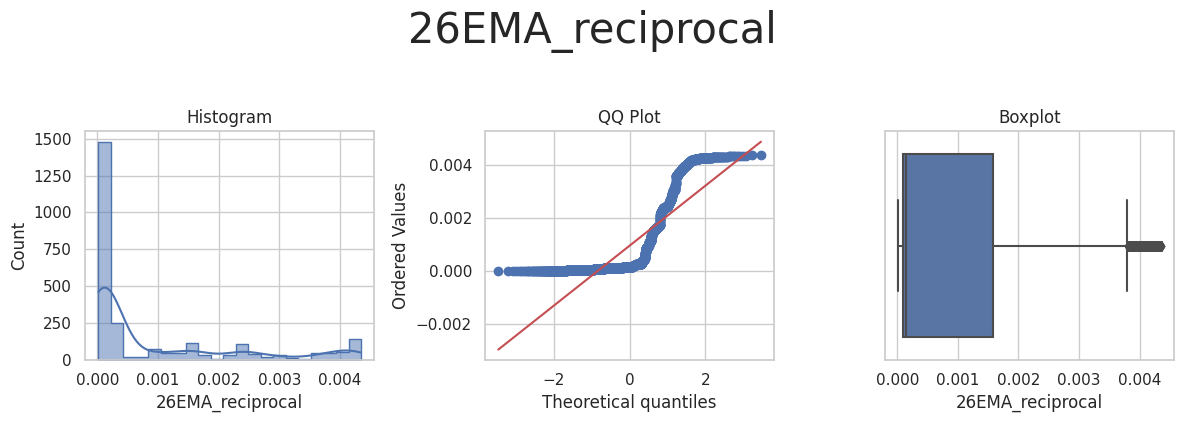

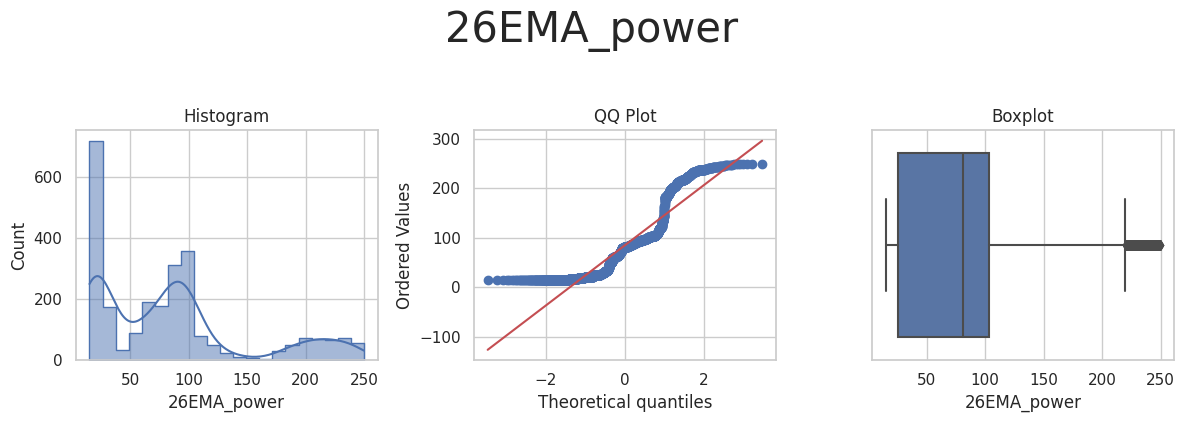

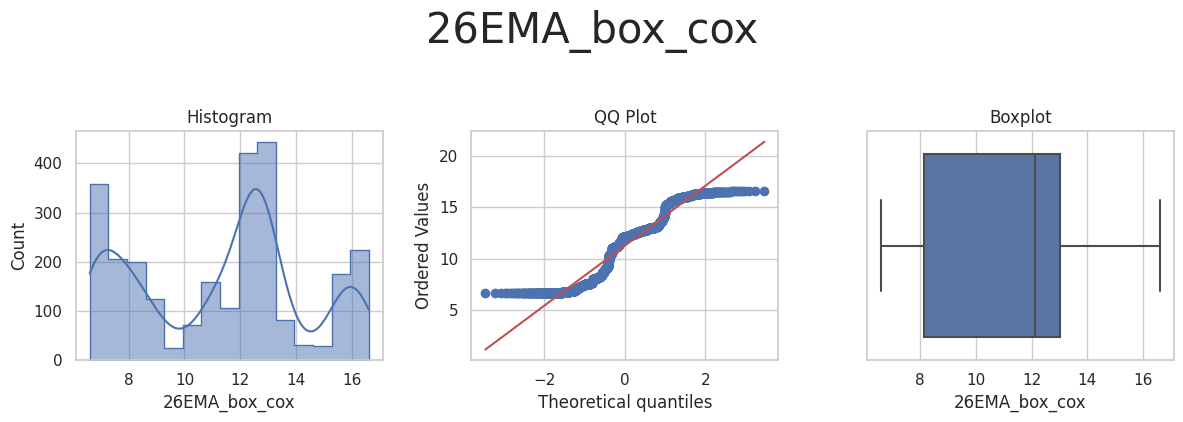

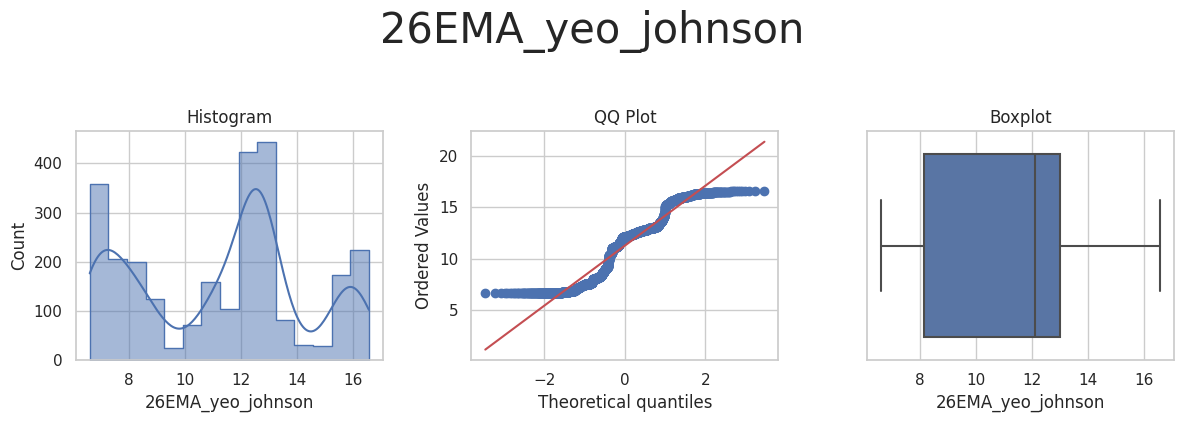



* Variable Analyzed: MACD
* Applied transformation: ['MACD_reciprocal', 'MACD_power', 'MACD_yeo_johnson'] 



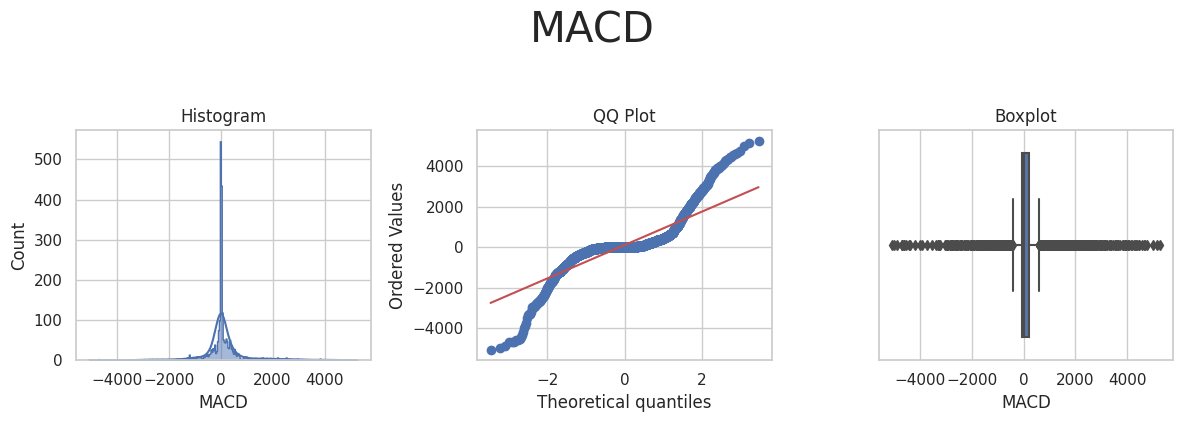

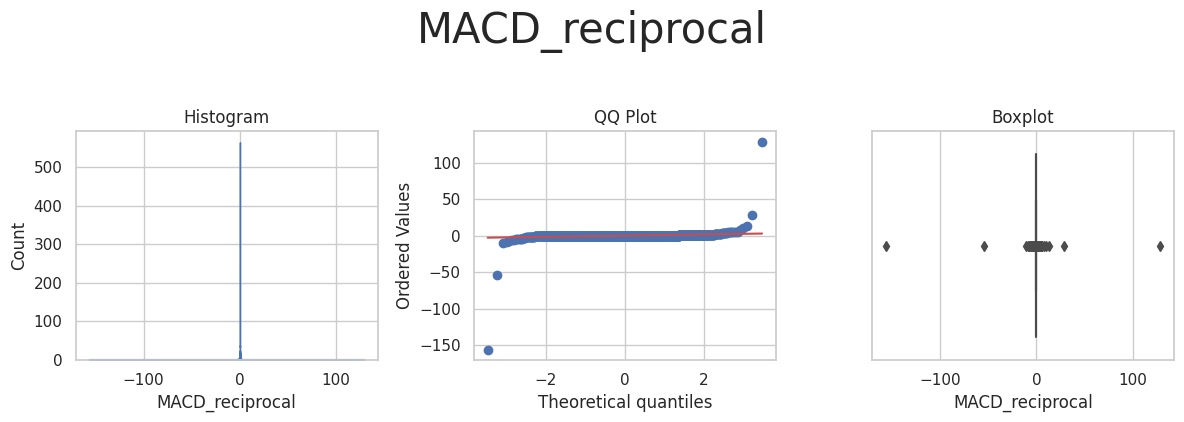

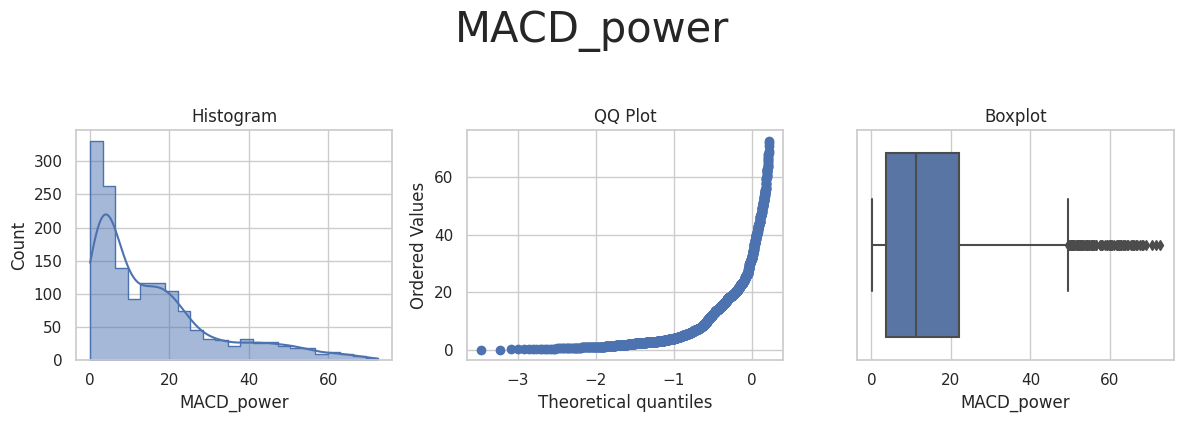

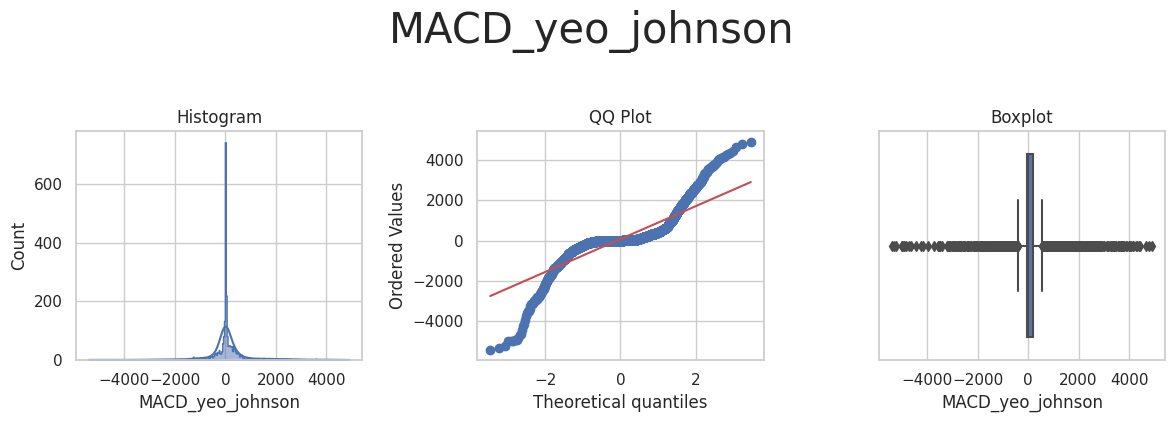

In [13]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering,analysis_type='numerical')

## SmartCorrelatedSelection Variables

Step 1: Create a separate DataFrame

In [14]:
df_engineering = df.copy() 
df_engineering.head(5)

open    high     low   close  Volume BTC  Volume USD  \
date                                                                 
2014-11-29  376.42  386.60  372.25  376.72  2746157.05     7245.19   
2014-11-30  376.57  381.99  373.32  373.34  1145566.61     3046.33   
2014-12-01  376.40  382.31  373.03  378.39  2520662.37     6660.56   
2014-12-02  378.39  382.86  375.23  379.25  2593576.46     6832.53   
2014-12-03  379.25  383.00  374.23  376.67  2998357.92     7908.29   

            price mean  upper shadow  lower shadow  spread  trade       12EMA  \
date                                                                            
2014-11-29    377.9975          9.88          4.17   14.35   0.30  376.347692   
2014-11-30    376.3050          5.42          0.02    8.67  -3.23  375.884970   
2014-12-01    377.5325          3.92          3.37    9.28   1.99  376.270360   
2014-12-02    378.9325          3.61          3.16    7.63   0.86  376.728766   
2014-12-03    378.2875          3.75          2.44    8.77  -2.58  376.719725   

                 26EMA      MACD  buy/sell  
date                                        
2014-11-29  376.312593  0.035100         1  
2014-11-30  376.092401 -0.207430         0  
2014-12-01  376.262593  0.007766         1  
2014-12-02  376.483883  0.244883         1  
2014-12-03  376.497669  0.222056         0

Step 2: Create engineered variables applying the transformations

In [16]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures

pipeline_regression = Pipeline([
    ('drop_features', DropFeatures(features_to_drop=['close'])),  # Drop the target variable
    ('numerical_transformation', vt.YeoJohnsonTransformer(variables=['open', 'high', 'low', 'Volume BTC', 'Volume USD', 
                         'price mean', 'upper shadow', 'lower shadow', 
                         'spread', '12EMA', '26EMA']))  
])

df_regression = pipeline_regression.fit_transform(df_engineering)
df_regression.head()

open      high       low  Volume BTC  Volume USD  price mean  \
date                                                                           
2014-11-29  7.386992  7.442810  7.367059   10.354492   11.407851    7.400288   
2014-11-30  7.387599  7.424442  7.371424    9.938988   10.040247    7.393440   
2014-12-01  7.386911  7.425723  7.370242   10.314598   11.272214    7.398409   
2014-12-02  7.394943  7.427924  7.379187   10.327895   11.313245    7.404059   
2014-12-03  7.398403  7.428483  7.375127   10.395219   11.549691    7.401458   

            upper shadow  lower shadow    spread  trade     12EMA     26EMA  \
date                                                                          
2014-11-29      2.373122      1.646509  2.973158   0.30  7.367005  7.335494   
2014-11-30      1.851034      0.019803  2.434485  -3.23  7.365141  7.334614   
2014-12-01      1.587150      1.477693  2.504922   1.99  7.366694  7.335294   
2014-12-02      1.522561      1.428252  2.304168   0.86  7.368539  7.336178   
2014-12-03      1.552254      1.237527  2.446313  -2.58  7.368503  7.336233   

                MACD  buy/sell  
date                            
2014-11-29  0.035100         1  
2014-11-30 -0.207430         0  
2014-12-01  0.007766         1  
2014-12-02  0.244883         1  
2014-12-03  0.222056         0

In [17]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_regression)
corr_sel.correlated_feature_sets_

[{'12EMA',
  '26EMA',
  'Volume BTC',
  'Volume USD',
  'high',
  'low',
  'lower shadow',
  'open',
  'price mean',
  'spread',
  'upper shadow'},
 {'buy/sell', 'trade'}]

In [18]:
corr_sel.features_to_drop_

['open',
 'high',
 'low',
 'Volume BTC',
 'price mean',
 'upper shadow',
 'lower shadow',
 'spread',
 '12EMA',
 '26EMA',
 'buy/sell']

In [20]:
pipeline_classification = Pipeline([
    ('drop_features', DropFeatures(features_to_drop=['buy/sell'])),  # Drop the target variable
    ('numerical_transformation', vt.YeoJohnsonTransformer(variables=['open', 'close', 'high', 'low', 'Volume BTC', 'Volume USD', 
                         'price mean', 'upper shadow', 'lower shadow', 
                         'spread', '12EMA', '26EMA']))  # Include 'close' 
])

df_classification = pipeline_classification.fit_transform(df_engineering)
df_classification.head()

open      high       low     close  Volume BTC  Volume USD  \
date                                                                         
2014-11-29  7.386992  7.442810  7.367059  7.397115   10.354492   11.407851   
2014-11-30  7.387599  7.424442  7.371424  7.383362    9.938988   10.040247   
2014-12-01  7.386911  7.425723  7.370242  7.403869   10.314598   11.272214   
2014-12-02  7.394943  7.427924  7.379187  7.407336   10.327895   11.313245   
2014-12-03  7.398403  7.428483  7.375127  7.396913   10.395219   11.549691   

            price mean  upper shadow  lower shadow    spread  trade     12EMA  \
date                                                                            
2014-11-29    7.400288      2.373122      1.646509  2.973158   0.30  7.367005   
2014-11-30    7.393440      1.851034      0.019803  2.434485  -3.23  7.365141   
2014-12-01    7.398409      1.587150      1.477693  2.504922   1.99  7.366694   
2014-12-02    7.404059      1.522561      1.428252  2.304168   0.86  7.368539   
2014-12-03    7.401458      1.552254      1.237527  2.446313  -2.58  7.368503   

               26EMA      MACD  
date                            
2014-11-29  7.335494  0.035100  
2014-11-30  7.334614 -0.207430  
2014-12-01  7.335294  0.007766  
2014-12-02  7.336178  0.244883  
2014-12-03  7.336233  0.222056

In [21]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_classification)
corr_sel.correlated_feature_sets_

[{'12EMA',
  '26EMA',
  'Volume BTC',
  'Volume USD',
  'close',
  'high',
  'low',
  'lower shadow',
  'open',
  'price mean',
  'spread',
  'upper shadow'}]

In [22]:
corr_sel.features_to_drop_

['open',
 'high',
 'low',
 'close',
 'Volume BTC',
 'price mean',
 'upper shadow',
 'lower shadow',
 'spread',
 '12EMA',
 '26EMA']

# Save DataFrame

In [23]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') 
except Exception as e:
  print(e)

df.to_csv(f"outputs/datasets/cleaned/BTCAugmentedV2.csv",index=True)

[Errno 17] File exists: 'outputs/datasets/cleaned'


# Conclusions

The list below shows the transformations needed for feature engineering. These steps will be added to the machine learning pipelines for both regression and classification models.

### Feature Engineering Transformers 

Classification Pipeline:

* Yeo-Johnson Transformation: ['open', 'close', 'high', 'low', 'Volume BTC', 'Volume USD', 'price mean', 'upper shadow', 'lower shadow', 'spread', '10 period SMA', '50 period SMA', '100 period SMA', '12EMA', '26EMA']
* Smart Correlation Selection: ['open', 'high', 'low', 'close', 'Volume BTC', 'price mean', 'upper shadow', 'lower shadow', 'spread', '10 period SMA', '50 period SMA', '100 period SMA', '12EMA', '26EMA']

Regression Pipeline:

* Yeo-Johnson Transformation: ['open', 'high', 'low', 'Volume BTC', 'Volume USD', 'price mean', 'upper shadow', 'lower shadow', 'spread', '10 period SMA', '50 period SMA', '100 period SMA', '12EMA', '26EMA']
* Smart Correlation Selection: ['open', 'high', 'low', 'Volume BTC', 'price mean', 'upper shadow', 'lower shadow', 'spread', '10 period SMA', '50 period SMA', '100 period SMA', '12EMA', '26EMA', 'buy/sell']

Note: In version 2 of the regression model, the 10, 50, and 100 SMAs were not utilized as features.